In [ ]:
import os
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

# 환경 변수 가져오기
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME") 
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [ ]:
from sqlalchemy import create_engine, text
import pymysql
import pandas as pd
db_connection_str = f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
db_connection = create_engine(db_connection_str)
conn = db_connection.connect()

C:\Users\ghtjq\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 군집별 특성 평균값 비교 (막대 그래프)
def plot_cluster_feature_comparison(df, cluster_column='cluster', feature_columns=None):
    """군집별 특성 평균값 비교 막대 그래프"""
    if feature_columns is None:
        feature_columns = df.columns.drop(cluster_column).tolist()
    
    # 군집별 평균값 계산
    cluster_means = df.groupby(cluster_column)[feature_columns].mean()
    
    # 시각화
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(feature_columns))
    width = 0.8 / len(cluster_means)
    
    colors = ['#440154', '#31688e', '#35b779', '#fde725']  # viridis 계열 색상
    
    for i, (cluster_id, values) in enumerate(cluster_means.iterrows()):
        offset = (i - len(cluster_means)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, 
                     label=f'군집 {cluster_id}', 
                     color=colors[i % len(colors)], alpha=0.8)
    
    ax.set_xlabel('특성')
    ax.set_ylabel('평균값 (Mean Value)')
    ax.set_title('군집별 특성 평균값 비교', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(feature_columns, rotation=45, ha='right')
    ax.legend(title='군집 (Cluster)')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# 2. 군집별 특성 관계 시각화 (페어플롯)
def plot_cluster_pairplot(df, cluster_column='cluster', feature_columns=None):
    """군집별 특성 관계 시각화 (페어플롯)"""
    if feature_columns is None:
        feature_columns = df.columns.drop(cluster_column).tolist()
    
    # 데이터 준비
    plot_df = df[feature_columns + [cluster_column]].copy()
    
    # 색상 팔레트 설정
    n_clusters = plot_df[cluster_column].nunique()
    colors = ['#440154', '#31688e', '#35b779', '#fde725'][:n_clusters]
    
    # 페어플롯 생성
    g = sns.PairGrid(plot_df, hue=cluster_column, palette=colors, height=2.5)
    
    # 대각선: 히스토그램 + KDE
    g.map_diag(sns.histplot, alpha=0.6, kde=True)
    
    # 비대각선: 산점도
    g.map_offdiag(sns.scatterplot, alpha=0.6, s=30, edgecolor='black', linewidth=0.5)
    
    # 범례 추가
    g.add_legend(title='군집 (Cluster)', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle('군집별 특성 관계 시각화 (페어 플롯)', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# 3. 군집별 특성 분포 비교 (바이올린 플롯)
def plot_cluster_violin_distribution(df, cluster_column='cluster', feature_columns=None):
    """군집별 특성 분포 비교 (바이올린 플롯)"""
    if feature_columns is None:
        feature_columns = df.columns.drop(cluster_column).tolist()
    
    # 데이터 변환 (wide to long format)
    df_melted = df.melt(id_vars=[cluster_column], 
                        value_vars=feature_columns,
                        var_name='특성', value_name='정규화된 값')
    
    # 시각화
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 바이올린 플롯
    sns.violinplot(data=df_melted, x='특성', y='정규화된 값', hue=cluster_column,
                   palette=['#440154', '#31688e', '#35b779', '#fde725'], 
                   split=False, inner='quart', ax=ax)
    
    ax.set_xlabel('특성')
    ax.set_ylabel('정규화된 값 (Value Distribution)')
    ax.set_title('군집별 특성 분포 비교 (바이올린 플롯)', fontsize=16, fontweight='bold')
    ax.legend(title='군집 (Cluster)', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    # x축 레이블 회전
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 4. 군집별 특성 레이더 차트
def plot_cluster_radar_chart(df, cluster_column='cluster', feature_columns=None):
    """군집별 특성 레이더 차트"""
    if feature_columns is None:
        feature_columns = df.columns.drop(cluster_column).tolist()
    
    # 군집별 평균값 계산
    cluster_means = df.groupby(cluster_column)[feature_columns].mean()
    
    # 각도 계산
    angles = np.linspace(0, 2 * np.pi, len(feature_columns), endpoint=False).tolist()
    angles += angles[:1]  # 원형으로 만들기 위해 첫 번째 각도를 마지막에 추가
    
    # 시각화
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, (cluster_id, values) in enumerate(cluster_means.iterrows()):
        values_list = values.tolist()
        values_list += values_list[:1]  # 원형으로 만들기 위해 첫 번째 값을 마지막에 추가
        
        ax.plot(angles, values_list, 'o-', linewidth=2, 
               label=f'Cluster {cluster_id}', color=colors[i % len(colors)])
        ax.fill(angles, values_list, alpha=0.25, color=colors[i % len(colors)])
    
    # 특성 레이블 설정
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_columns)
    
    # 제목과 범례
    ax.set_title('클러스터별 특성 레이더 차트', size=20, fontweight='bold', pad=20, color='blue')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# 5. 종합 분석 함수
def comprehensive_cluster_analysis(df, cluster_column='cluster', feature_columns=None):
    """종합적인 클러스터 분석 시각화"""
    if feature_columns is None:
        feature_columns = df.columns.drop(cluster_column).tolist()
    
    print("=" * 60)
    print("종합 클러스터 특성 분석")
    print("=" * 60)
    
    # 기본 통계 정보
    print(f"\n데이터 크기: {df.shape}")
    print(f"클러스터 개수: {df[cluster_column].nunique()}")
    print(f"분석 특성: {feature_columns}")
    
    cluster_counts = df[cluster_column].value_counts().sort_index()
    print(f"\n클러스터별 데이터 개수:")
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  클러스터 {cluster_id}: {count}개 ({percentage:.1f}%)")
    
    # 1. 막대 그래프
    print(f"\n1. 군집별 특성 평균값 비교")
    plot_cluster_feature_comparison(df, cluster_column, feature_columns)
    
    # 2. 페어플롯
    print(f"\n2. 군집별 특성 관계 시각화")
    plot_cluster_pairplot(df, cluster_column, feature_columns)
    
    # 3. 바이올린 플롯
    print(f"\n3. 군집별 특성 분포 비교")
    plot_cluster_violin_distribution(df, cluster_column, feature_columns)
    
    # 4. 레이더 차트
    print(f"\n4. 군집별 특성 레이더 차트")
    plot_cluster_radar_chart(df, cluster_column, feature_columns)

In [ ]:
import numpy as np

merged_df = pd.read_sql_query(text('SELECT * FROM final_df'), conn)
# merged_df = pd.read_csv('data/final_df.csv')
merged_df.head()

,결혼이민자 비율,장애인구 비율,고령인구 비율,기초생활수급자 비율,점포 당 인구수,trafic_infra,SIGUNGU_CD,행정구역_수정
0,0.002250,0.062619,0.237448,0.061075,13361.625,-2.305463e-08,32030,강원도 강릉시
1,0.002553,0.080220,0.302326,0.054619,13905.500,-1.511527e-09,32600,강원도 고성군
2,0.002668,0.077208,0.238547,0.065958,10777.750,-3.860876e-08,32040,강원도 동해시
3,0.002534,0.084007,0.273945,0.064272,12708.400,-1.110651e-07,32070,강원도 삼척시
4,0.002708,0.060623,0.226331,0.070326,10062.125,-5.004629e-07,32060,강원도 속초시


In [5]:
from sklearn.preprocessing import RobustScaler

# 1. 변환 및 스케일링을 적용할 피처(컬럼)들을 선택합니다.
#    (행정구역과 같은 텍스트 데이터는 제외합니다.)
features = merged_df.iloc[:, :-2]

# 2. 로그 변환 (Log Transformation)
# np.log1p는 각 값에 1을 더한 후 로그를 취합니다.
# 이는 데이터에 0이 포함되어 있어도 오류 없이 안전하게 변환하기 위함입니다.
log_transformed_features = features.apply(np.log1p)

print("\n--- 2. 로그 변환 후 데이터 ---")
print(log_transformed_features.head())

# 3. RobustScaler 적용
# RobustScaler는 중앙값(median)과 사분위수(IQR)를 사용하므로 이상치에 강건합니다.
scaler = RobustScaler()

# 로그 변환된 데이터에 RobustScaler를 적용합니다.
robust_scaled_features_array = scaler.fit_transform(log_transformed_features)

# 스케일링 결과는 numpy 배열이므로 다시 pandas DataFrame으로 변환합니다.
# 컬럼 이름은 원래의 피처 이름을 그대로 사용합니다.
scaled_df = pd.DataFrame(robust_scaled_features_array, columns=merged_df.iloc[:, :-2].columns)

print("\n--- 3. 로그 변환 + Robust 스케일링 최종 완료된 데이터 ---")
print(scaled_df.head())


--- 2. 로그 변환 후 데이터 ---
   결혼이민자 비율   장애인구 비율   고령인구 비율  기초생활수급자 비율  점포 당 인구수  trafic_infra
0  0.002247  0.060736  0.213051    0.059283  9.500217 -2.305463e-08
1  0.002550  0.077165  0.264152    0.053179  9.540112 -1.511527e-09
2  0.002664  0.074372  0.213939    0.063874  9.285332 -3.860876e-08
3  0.002531  0.080665  0.242118    0.062291  9.450097 -1.110652e-07
4  0.002705  0.058857  0.204027    0.067963  9.216633 -5.004630e-07

--- 3. 로그 변환 + Robust 스케일링 최종 완료된 데이터 ---
   결혼이민자 비율   장애인구 비율   고령인구 비율  기초생활수급자 비율  점포 당 인구수  trafic_infra
0 -0.628698  0.079435  0.160655    0.158469  0.290776      0.468713
1 -0.430794  0.517456  0.619700   -0.069251  0.376042      0.471725
2 -0.355976  0.442999  0.168632    0.329760 -0.168494      0.466538
3 -0.443325  0.610773  0.421767    0.270728  0.183656      0.456409
4 -0.329441  0.029323  0.079594    0.482334 -0.315322      0.401971


In [15]:
scaled_df

,결혼이민자 비율,장애인구 비율,고령인구 비율,기초생활수급자 비율,점포 당 인구수,trafic_infra
0,-0.628698,0.079435,0.160655,0.158469,0.290776,0.468713
1,-0.430794,0.517456,0.619700,-0.069251,0.376042,0.471725
2,-0.355976,0.442999,0.168632,0.329760,-0.168494,0.466538
3,-0.443325,0.610773,0.421767,0.270728,0.183656,0.456409
4,-0.329441,0.029323,0.079594,0.482334,-0.315322,0.401971
...,...,...,...,...,...,...
245,-0.483980,-0.133773,-0.298703,-0.226631,0.120907,0.169357
246,-0.599365,-0.211269,-0.298908,-0.139589,0.711457,-0.276589
247,-0.095295,-0.358169,-0.516572,-0.750250,-0.143399,-0.050677
248,-0.169519,-0.518991,-0.666872,-0.897135,-0.240224,-0.431804


## K-means 군집화 성능

결혼이민자 데이터 군집분석 시작
데이터 크기: (250, 6)
특성: ['결혼이민자 비율', '장애인구 비율', '고령인구 비율', '기초생활수급자 비율', '점포 당 인구수', 'trafic_infra']

1. Elbow Method 분석


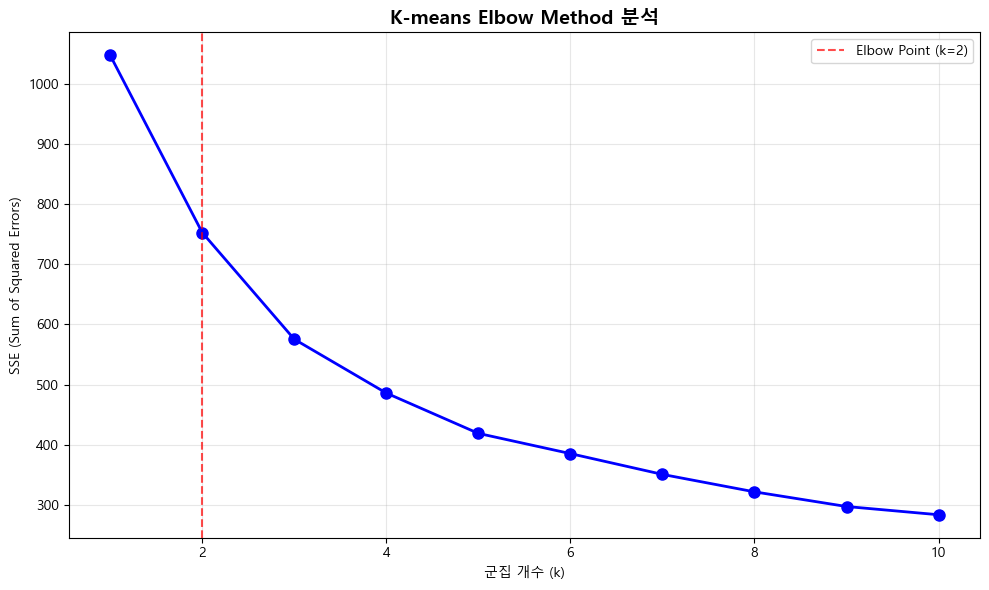

Elbow Method 최적 k: 2

2. 실루엣 계수 분석


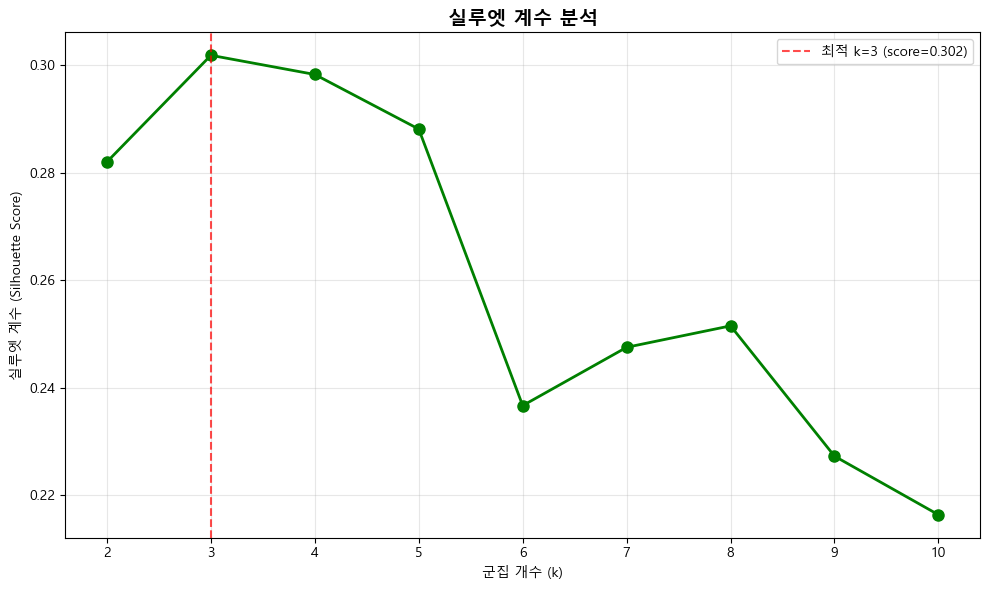

실루엣 계수 최적 k: 3, 최고 점수: 0.3018

3. 최적 k 결정
Elbow Method 추천: k=2
실루엣 계수 추천: k=3
최종 선택: k=3

4. k=3로 군집화 수행
군집 결과가 'clustered_data.csv'에 저장되었습니다.

=== 군집화 결과 (k=3) ===
군집 0: 100개 (40.0%)
군집 1: 127개 (50.8%)
군집 2: 23개 (9.2%)

5. PCA 2차원 시각화


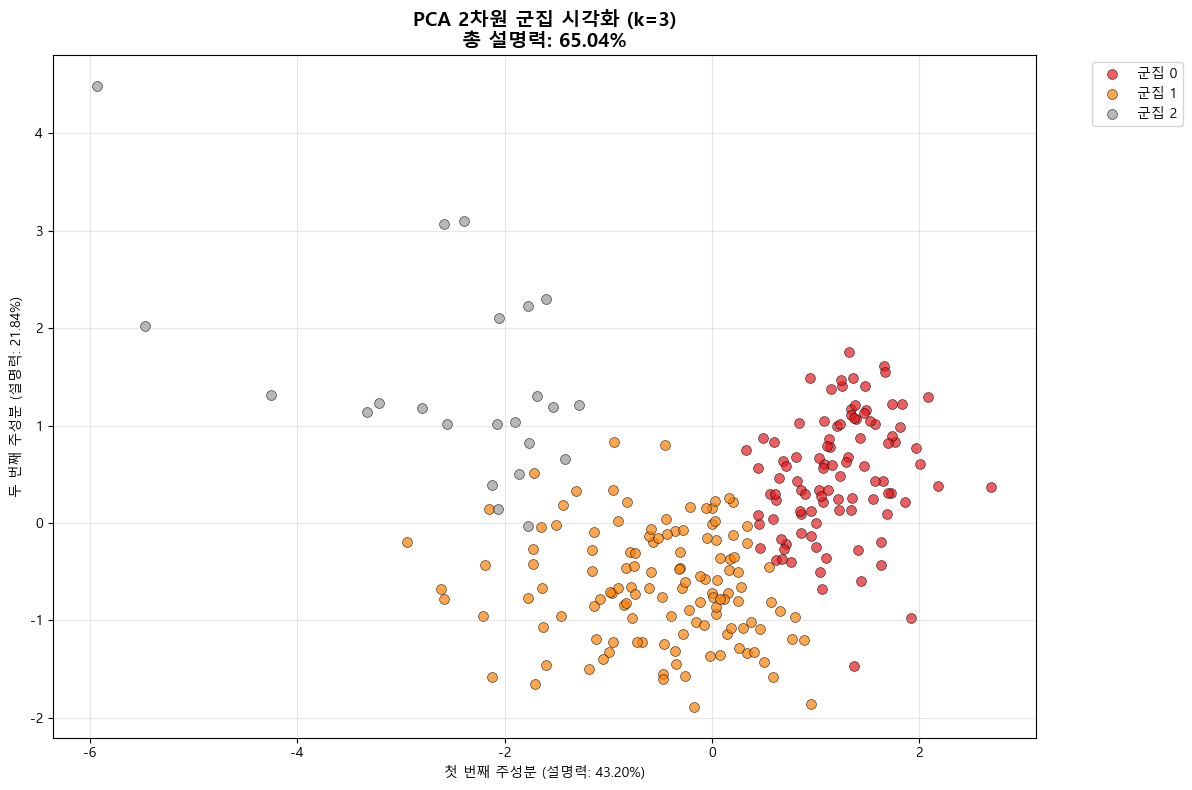


PCA 설명 분산 비율:
PC1: 43.20%
PC2: 21.84%
누적: 65.04%

6. 상세 실루엣 분석


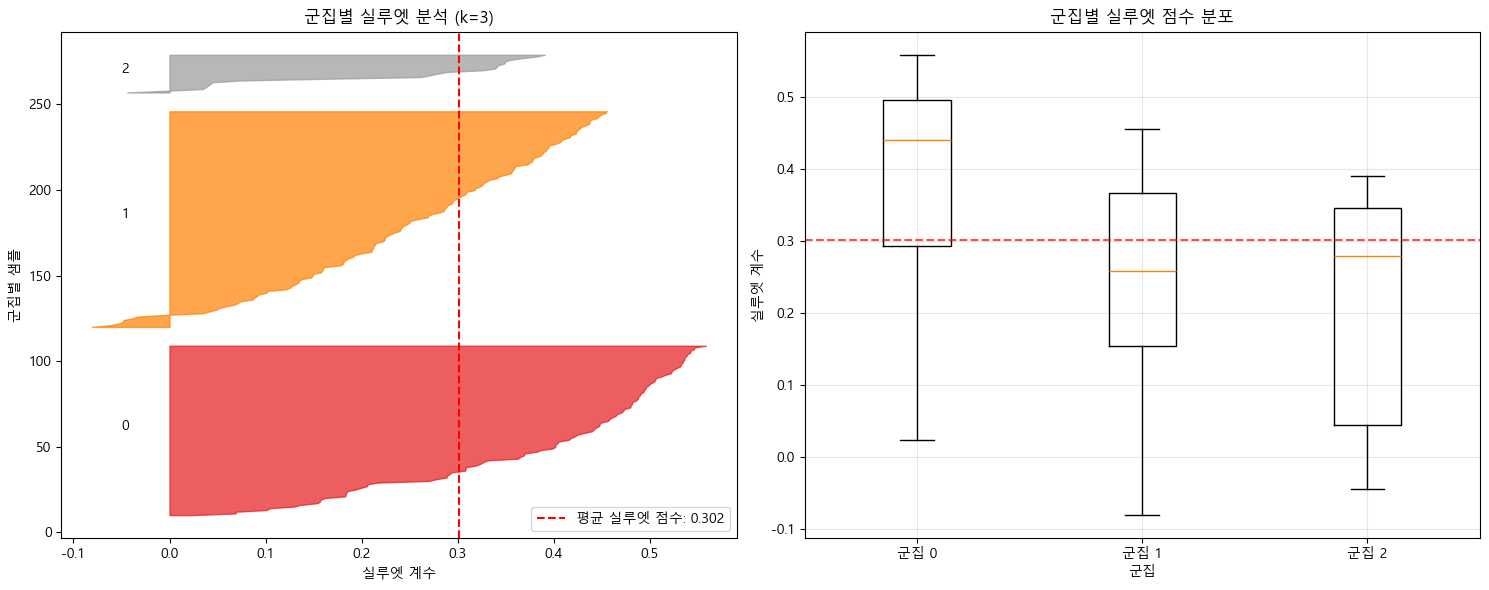


분석 완료!


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. Elbow Method 분석 및 시각화
def analyze_elbow_method(data, max_k=10):
    """Elbow Method로 최적 k 탐색"""
    k_range = range(1, max_k + 1)
    sse_values = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        sse_values.append(kmeans.inertia_)
    
    # Elbow point 자동 탐지
    first_diff = np.diff(sse_values)
    second_diff = np.diff(first_diff)
    elbow_k = np.argmax(second_diff) + 2  # 인덱스 보정
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse_values, 'o-', linewidth=2, markersize=8, color='blue')
    plt.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Elbow Point (k={elbow_k})')
    plt.title('K-means Elbow Method 분석', fontsize=14, fontweight='bold')
    plt.xlabel('군집 개수 (k)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Elbow Method 최적 k: {elbow_k}")
    return elbow_k, k_range, sse_values

# 2. 실루엣 계수 분석 및 시각화
def analyze_silhouette_score(data, max_k=10):
    """실루엣 계수로 최적 k 탐색"""
    k_range = range(2, max_k + 1)
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='green')
    plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7,
                label=f'최적 k={optimal_k} (score={max(silhouette_scores):.3f})')
    plt.title('실루엣 계수 분석', fontsize=14, fontweight='bold')
    plt.xlabel('군집 개수 (k)')
    plt.ylabel('실루엣 계수 (Silhouette Score)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"실루엣 계수 최적 k: {optimal_k}, 최고 점수: {max(silhouette_scores):.4f}")
    return optimal_k, silhouette_scores

# 3. 최적 k로 군집화 수행 및 저장
def perform_clustering(data, k, save_clusters=True):
    """최적 k로 군집화 수행 및 결과 저장"""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data)
    
    # 군집 결과를 DataFrame에 추가
    scaled_df_with_clusters = scaled_df.copy()
    scaled_df_with_clusters['cluster'] = clusters
    
    if save_clusters:
        # CSV 파일로 저장
        scaled_df_with_clusters.to_csv('data/kmeans_clustered_data.csv', index=False, encoding='utf-8-sig')
        print(f"군집 결과가 'clustered_data.csv'에 저장되었습니다.")
    
    # 군집별 통계 정보
    print(f"\n=== 군집화 결과 (k={k}) ===")
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(clusters)) * 100
        print(f"군집 {cluster_id}: {count}개 ({percentage:.1f}%)")
    
    return clusters, scaled_df_with_clusters, kmeans

# 4. PCA 2차원 시각화
def visualize_pca_clusters(data, clusters, k):
    """PCA를 사용한 2차원 군집 시각화"""
    # PCA 수행
    pca = PCA(n_components=2, random_state=42)
    data_pca = pca.fit_transform(data)
    
    # 시각화
    plt.figure(figsize=(12, 8))
    
    # 색상 팔레트 설정
    colors = plt.cm.Set1(np.linspace(0, 1, k))
    
    for i in range(k):
        cluster_data = data_pca[clusters == i]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                   c=[colors[i]], label=f'군집 {i}', 
                   alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    plt.xlabel(f'첫 번째 주성분 (설명력: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'두 번째 주성분 (설명력: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title(f'PCA 2차원 군집 시각화 (k={k})\n'
              f'총 설명력: {sum(pca.explained_variance_ratio_):.2%}', 
              fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPCA 설명 분산 비율:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"누적: {sum(pca.explained_variance_ratio_):.2%}")
    
    return data_pca, pca

# 5. 상세 실루엣 분석 (최적 k에 대해)
def detailed_silhouette_analysis(data, k):
    """최적 k에 대한 상세 실루엣 분석"""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data)
    
    # 전체 실루엣 점수
    silhouette_avg = silhouette_score(data, clusters)
    
    # 각 샘플의 실루엣 점수
    sample_silhouette_values = silhouette_samples(data, clusters)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 실루엣 플롯
    y_lower = 10
    colors = plt.cm.Set1(np.linspace(0, 1, k))
    
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        axes[0].fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        
        axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    axes[0].set_xlabel('실루엣 계수')
    axes[0].set_ylabel('군집별 샘플')
    axes[0].set_title(f'군집별 실루엣 분석 (k={k})')
    axes[0].axvline(x=silhouette_avg, color="red", linestyle="--", 
                   label=f'평균 실루엣 점수: {silhouette_avg:.3f}')
    axes[0].legend()
    
    # 군집별 실루엣 점수 박스플롯
    silhouette_data = [sample_silhouette_values[clusters == i] for i in range(k)]
    axes[1].boxplot(silhouette_data, labels=[f'군집 {i}' for i in range(k)])
    axes[1].set_xlabel('군집')
    axes[1].set_ylabel('실루엣 계수')
    axes[1].set_title('군집별 실루엣 점수 분포')
    axes[1].axhline(y=silhouette_avg, color="red", linestyle="--", alpha=0.7)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg, sample_silhouette_values

# === 메인 실행 코드 ===
print("=" * 60)
print("결혼이민자 데이터 군집분석 시작")
print("=" * 60)

# 데이터 준비 (이미 scaled_df가 있다고 가정)
data = scaled_df.values
print(f"데이터 크기: {scaled_df.shape}")
print(f"특성: {list(scaled_df.columns)}")

# 1. Elbow Method
print("\n1. Elbow Method 분석")
elbow_k, k_range, sse_values = analyze_elbow_method(data, max_k=10)

# 2. 실루엣 계수 분석
print("\n2. 실루엣 계수 분석")
silhouette_k, silhouette_scores = analyze_silhouette_score(data, max_k=10)

# 3. 최종 k 결정 (두 방법의 결과 종합)
print(f"\n3. 최적 k 결정")
print(f"Elbow Method 추천: k={elbow_k}")
print(f"실루엣 계수 추천: k={silhouette_k}")

# 실루엣 점수가 더 신뢰할 만한 지표이므로 우선 적용
final_k = silhouette_k
print(f"최종 선택: k={final_k}")

# 4. 군집화 수행 및 저장
print(f"\n4. k={final_k}로 군집화 수행")
clusters, clustered_df, kmeans = perform_clustering(data, final_k)

# 5. PCA 2차원 시각화
print(f"\n5. PCA 2차원 시각화")
data_pca, pca = visualize_pca_clusters(data, clusters, final_k)

# 6. 상세 실루엣 분석
print(f"\n6. 상세 실루엣 분석")
silhouette_avg, sample_silhouette_values = detailed_silhouette_analysis(data, final_k)

print("\n" + "=" * 60)
print("분석 완료!")
print("=" * 60)


종합 클러스터 특성 분석

데이터 크기: (250, 7)
클러스터 개수: 3
분석 특성: ['결혼이민자 비율', '장애인구 비율', '고령인구 비율', '기초생활수급자 비율', '점포 당 인구수', 'trafic_infra']

클러스터별 데이터 개수:
  클러스터 0: 100개 (40.0%)
  클러스터 1: 127개 (50.8%)
  클러스터 2: 23개 (9.2%)

1. 군집별 특성 평균값 비교


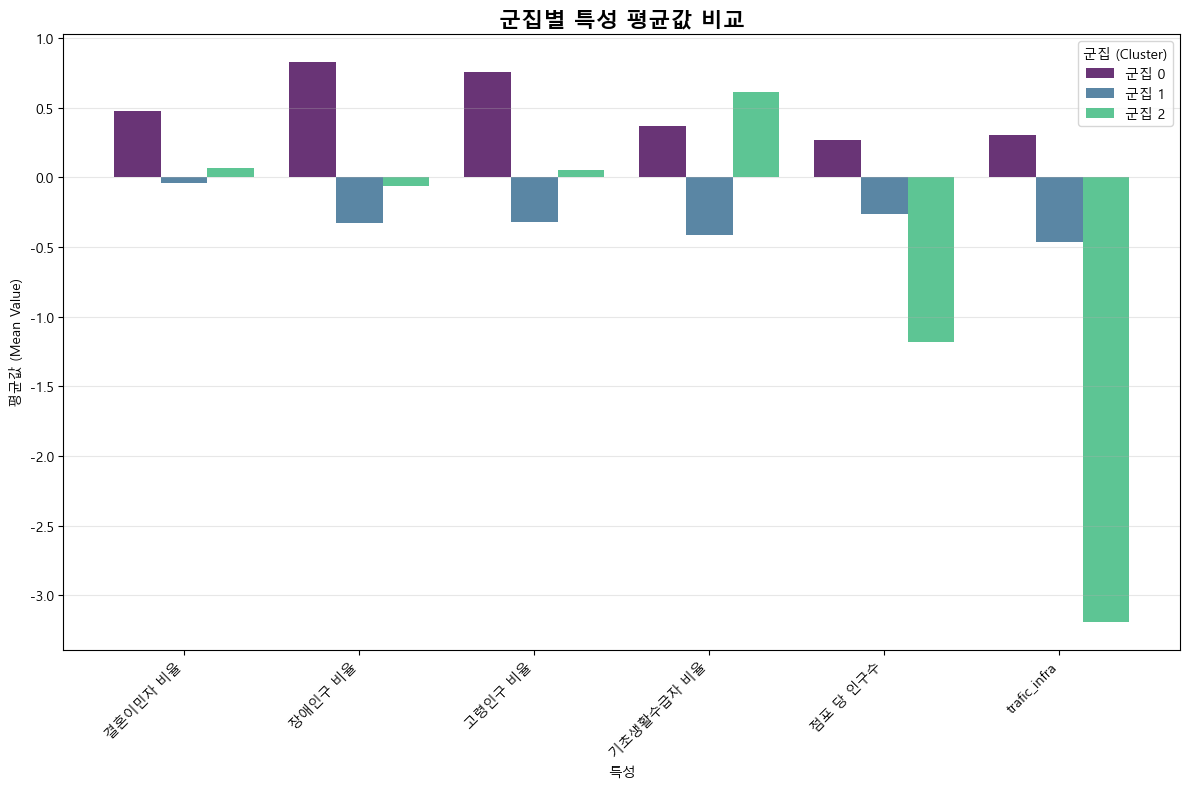


2. 군집별 특성 관계 시각화


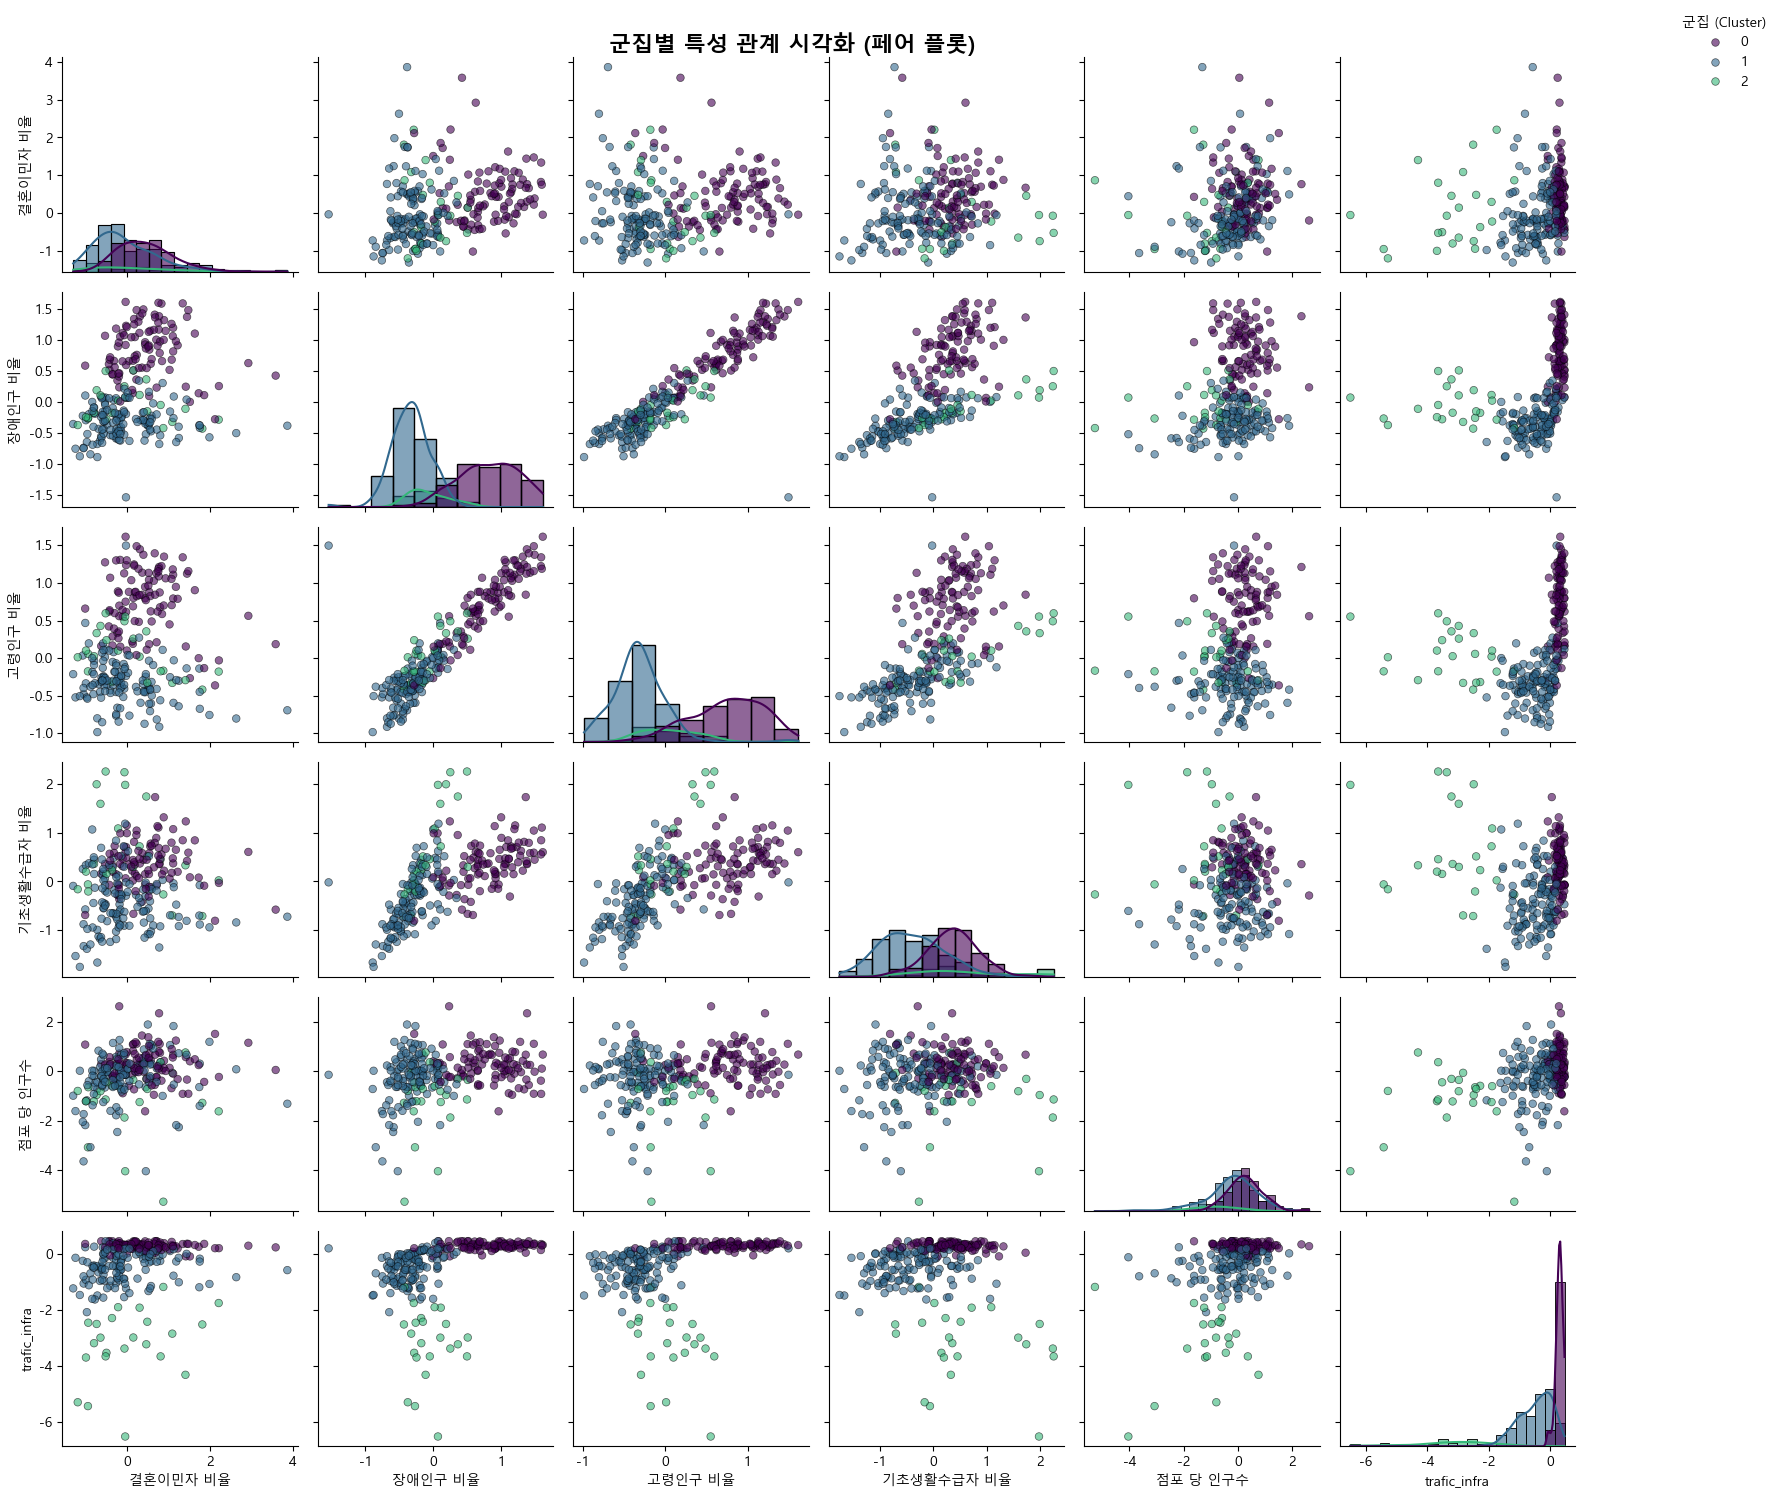


3. 군집별 특성 분포 비교


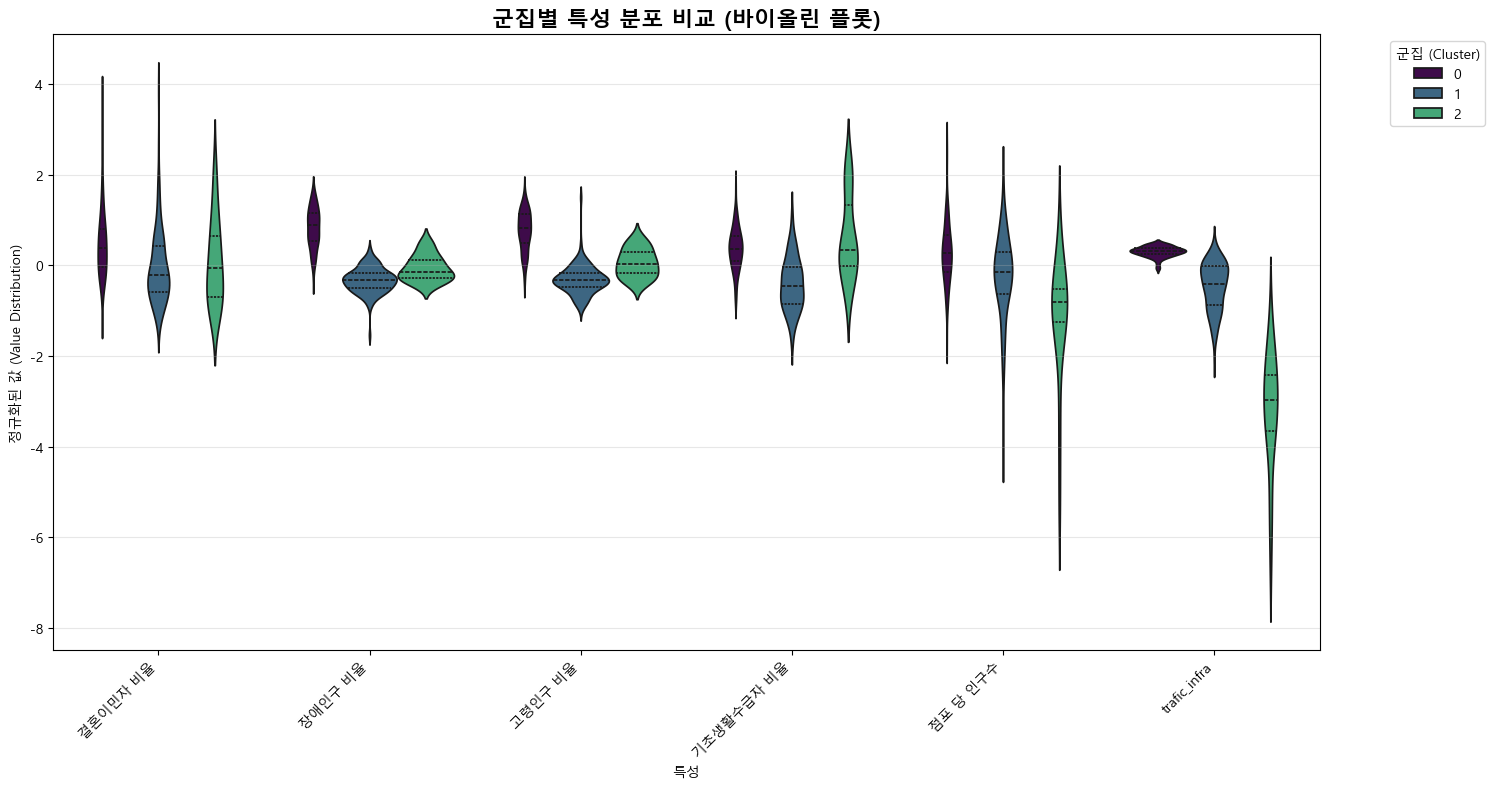


4. 군집별 특성 레이더 차트


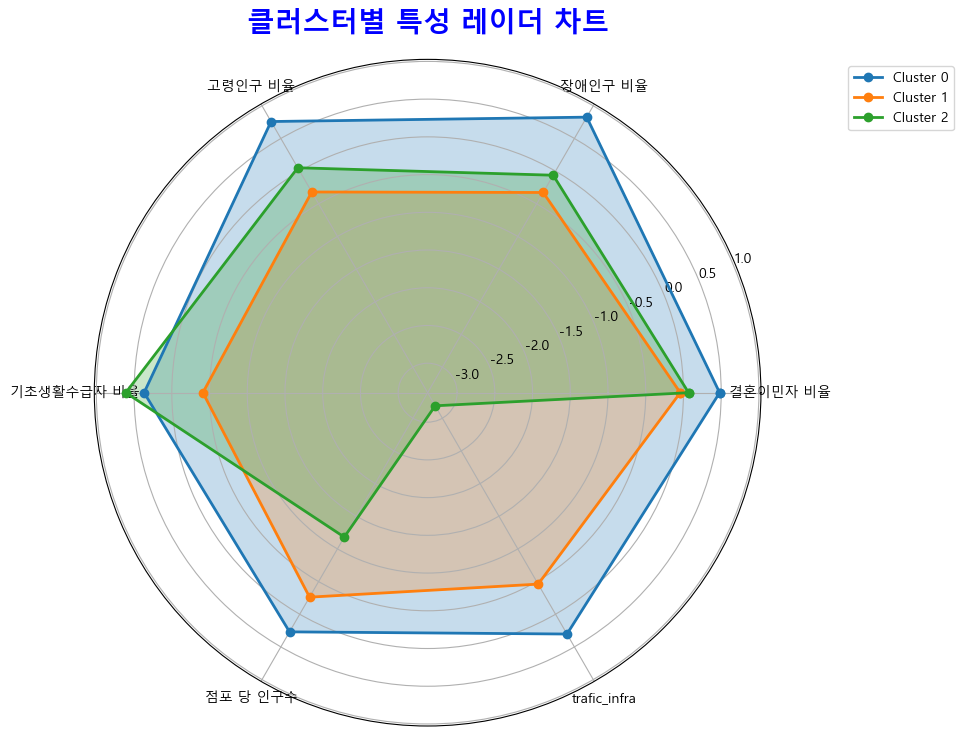

In [21]:
kmeans = pd.read_csv('data/kmeans_clustered_data.csv')
feature_cols = ['결혼이민자 비율', '장애인구 비율', '고령인구 비율', 
                   '기초생활수급자 비율', '점포 당 인구수', 'trafic_infra']
comprehensive_cluster_analysis(kmeans, cluster_column='cluster', feature_columns=feature_cols)

## 계층적 군집화 성능

결혼이민자 데이터 계층적 군집분석 시작
데이터 크기: (250, 6)
특성: ['결혼이민자 비율', '장애인구 비율', '고령인구 비율', '기초생활수급자 비율', '점포 당 인구수', 'trafic_infra']

1. 연결 방법별 성능 비교


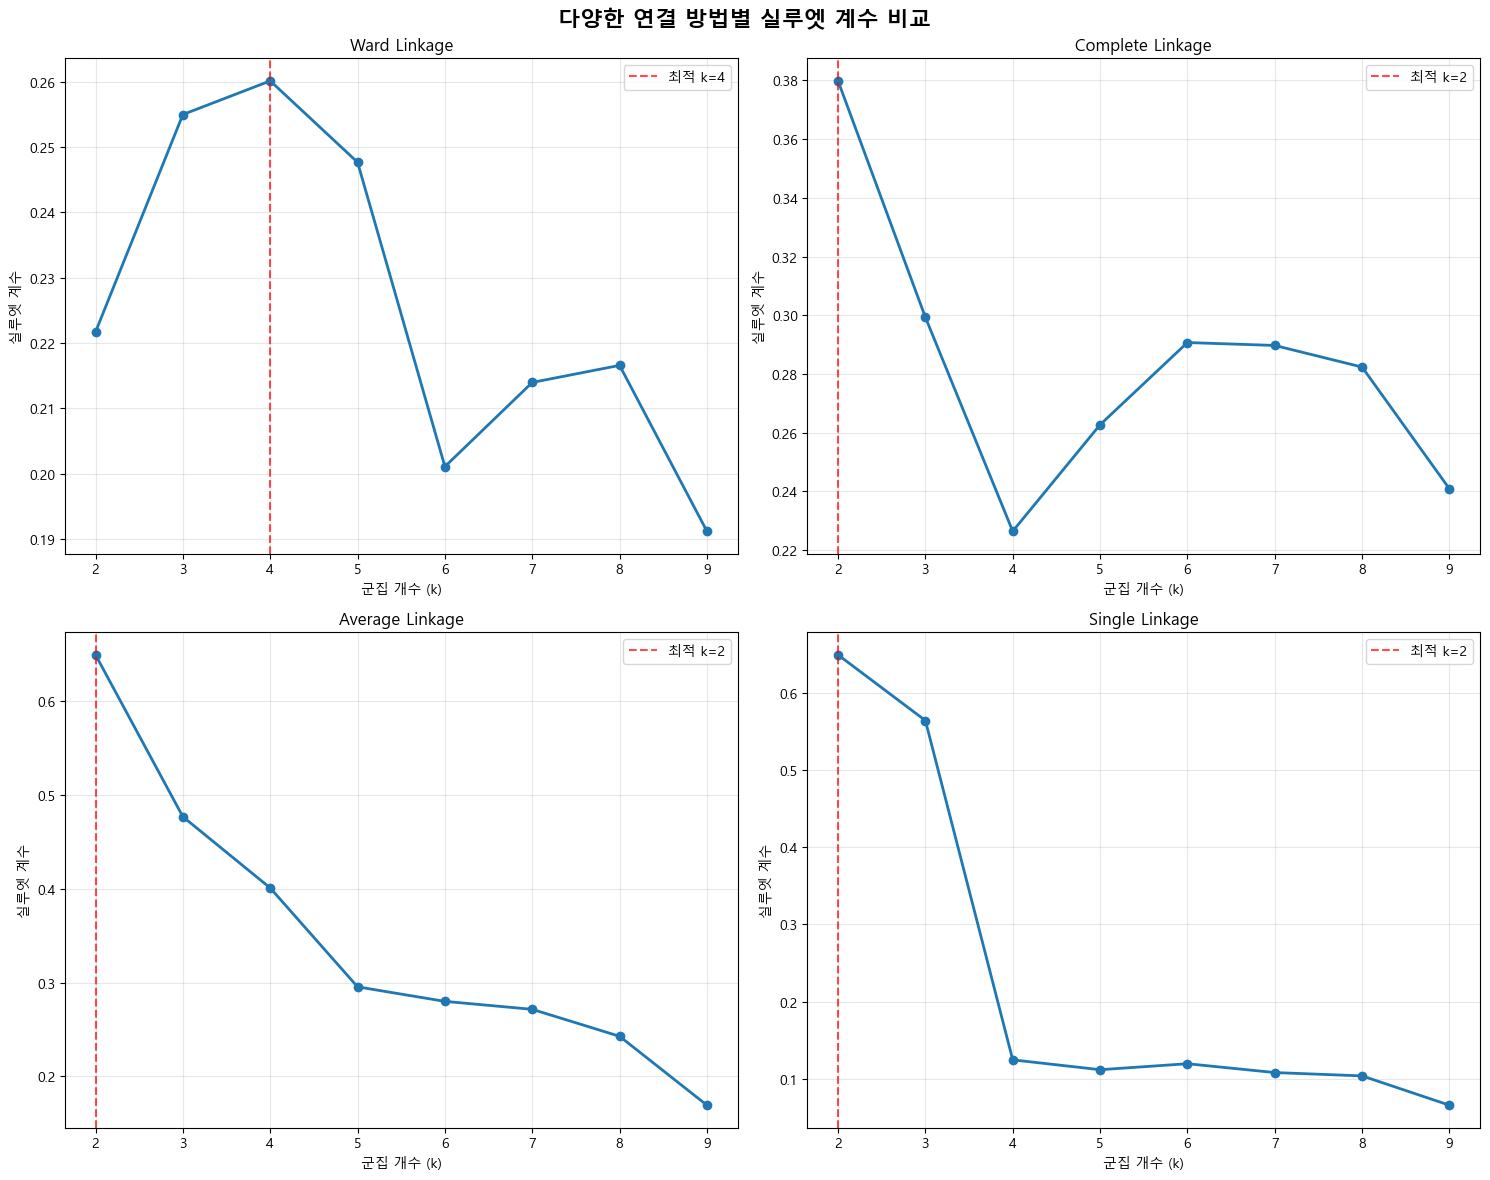

연결 방법별 최적 결과:
ward: k=4, 점수=0.2601
complete: k=2, 점수=0.3799
average: k=2, 점수=0.6494
single: k=2, 점수=0.6494

최고 성능 연결 방법: ward

2. 덴드로그램 시각화 (ward linkage)


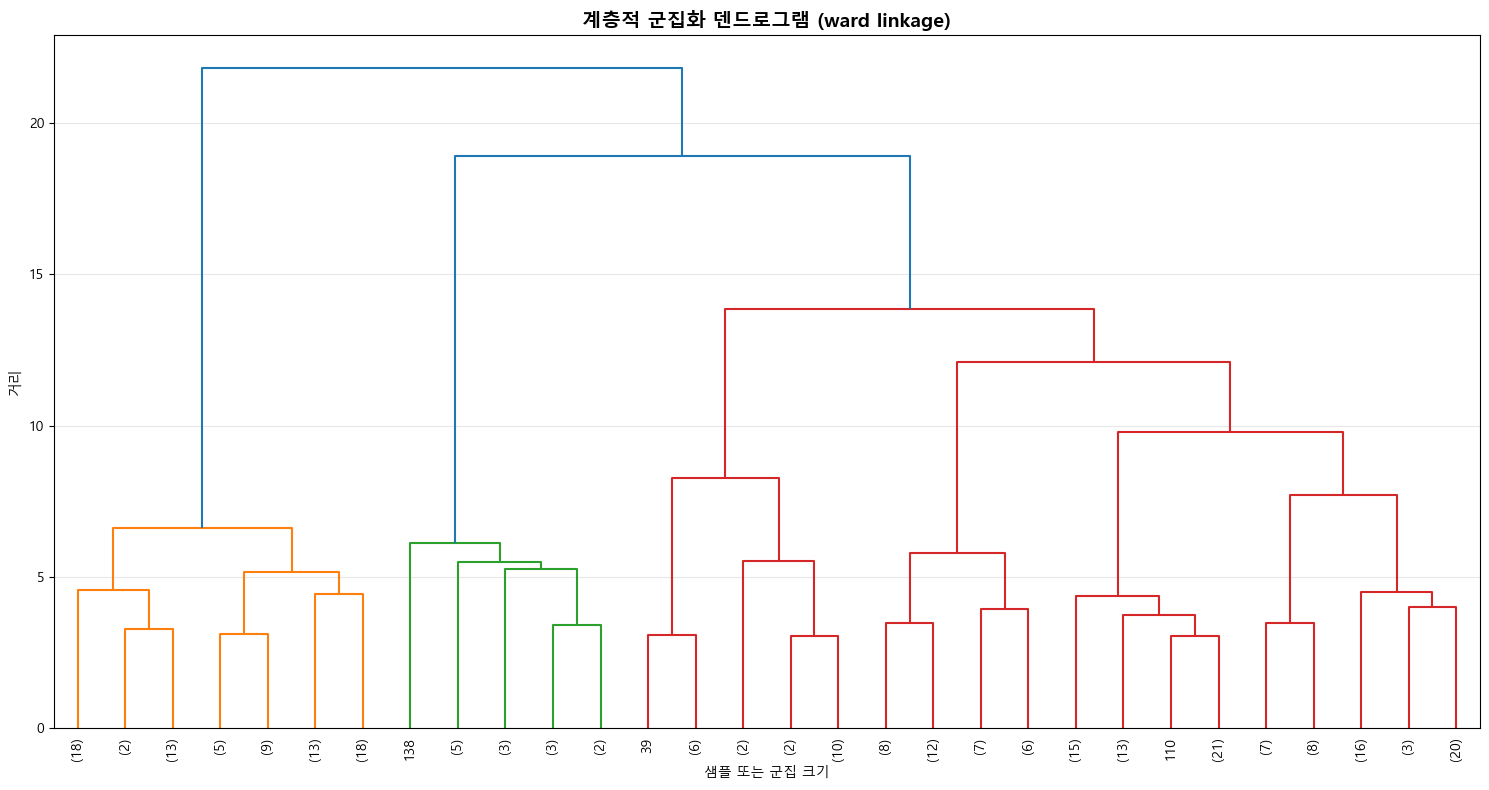


3. 계층적 군집화 Elbow Method 분석


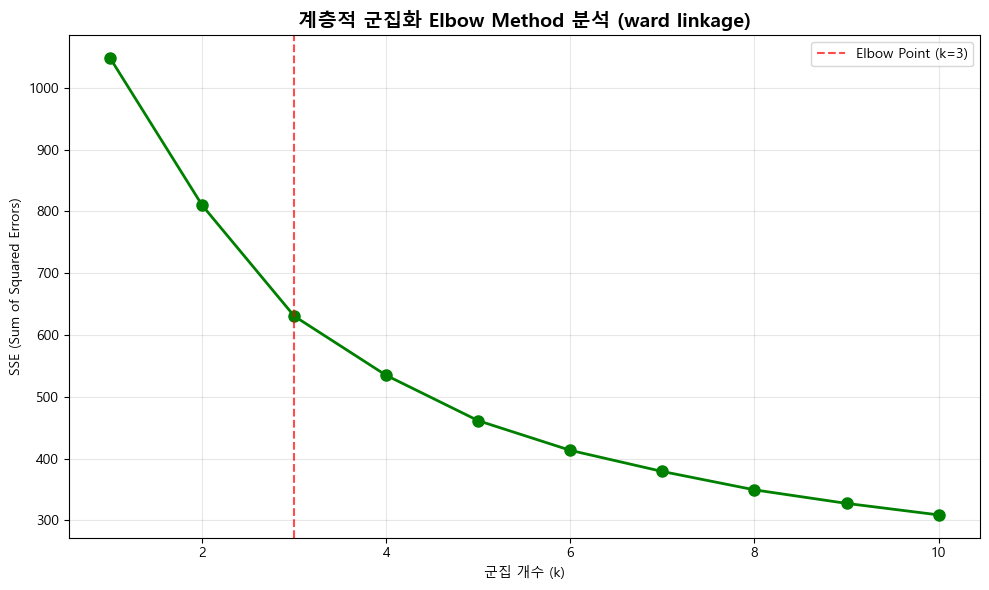

계층적 군집화 Elbow Method 최적 k: 3

4. 계층적 군집화 실루엣 계수 분석


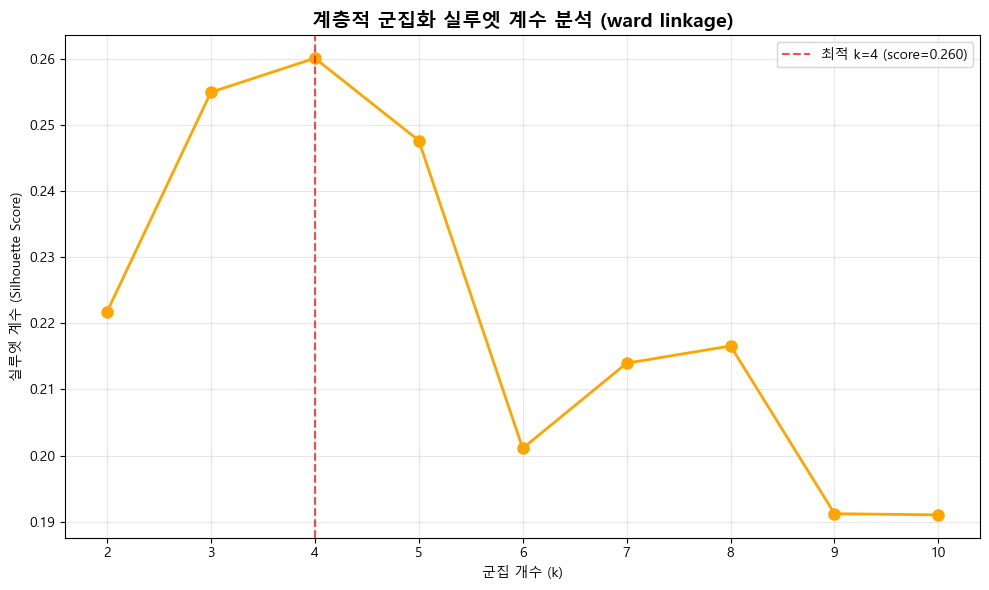

계층적 군집화 실루엣 계수 최적 k: 4, 최고 점수: 0.2601

5. 최적 k 결정
Elbow Method 추천: k=3
실루엣 계수 추천: k=4
최종 선택: k=4

6. k=4로 계층적 군집화 수행
계층적 군집 결과가 'hierarchical_clustered_data.csv'에 저장되었습니다.

=== 계층적 군집화 결과 (k=4, ward linkage) ===
군집 0: 137개 (54.8%)
군집 1: 21개 (8.4%)
군집 2: 14개 (5.6%)
군집 3: 78개 (31.2%)

7. PCA 2차원 시각화


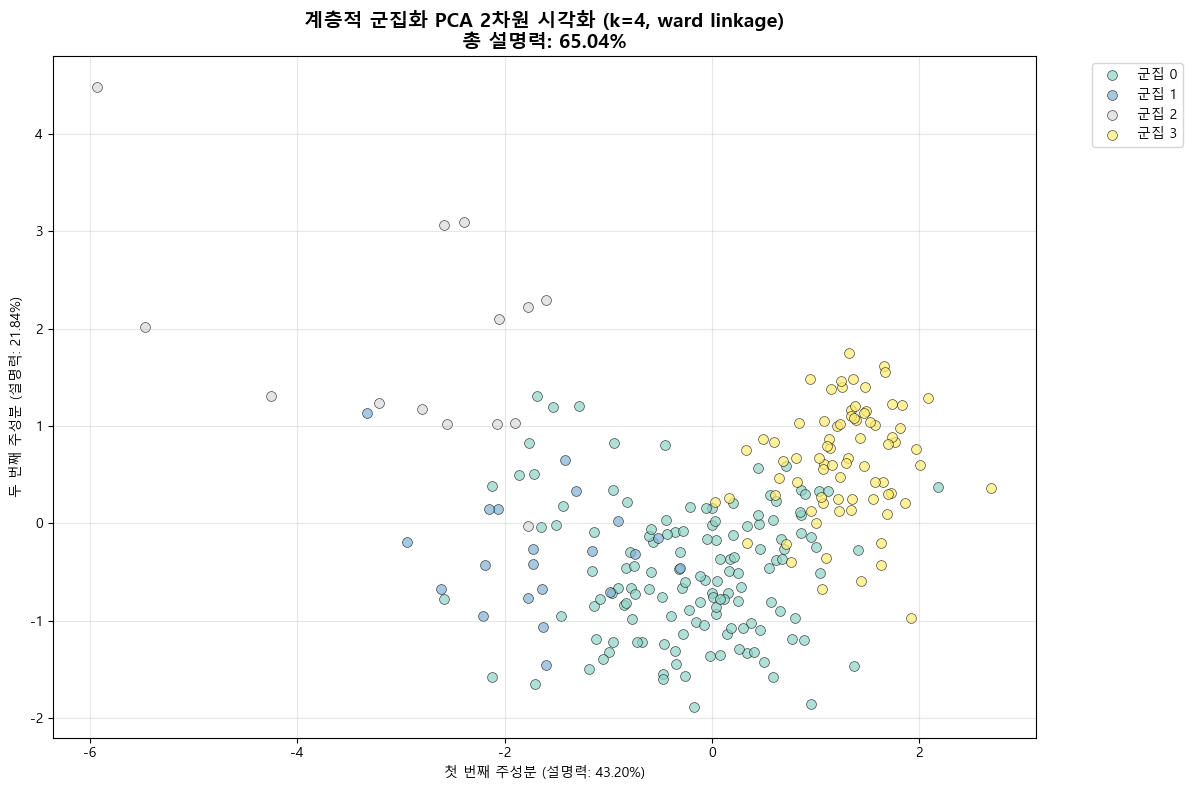


PCA 설명 분산 비율:
PC1: 43.20%
PC2: 21.84%
누적: 65.04%

8. 상세 실루엣 분석


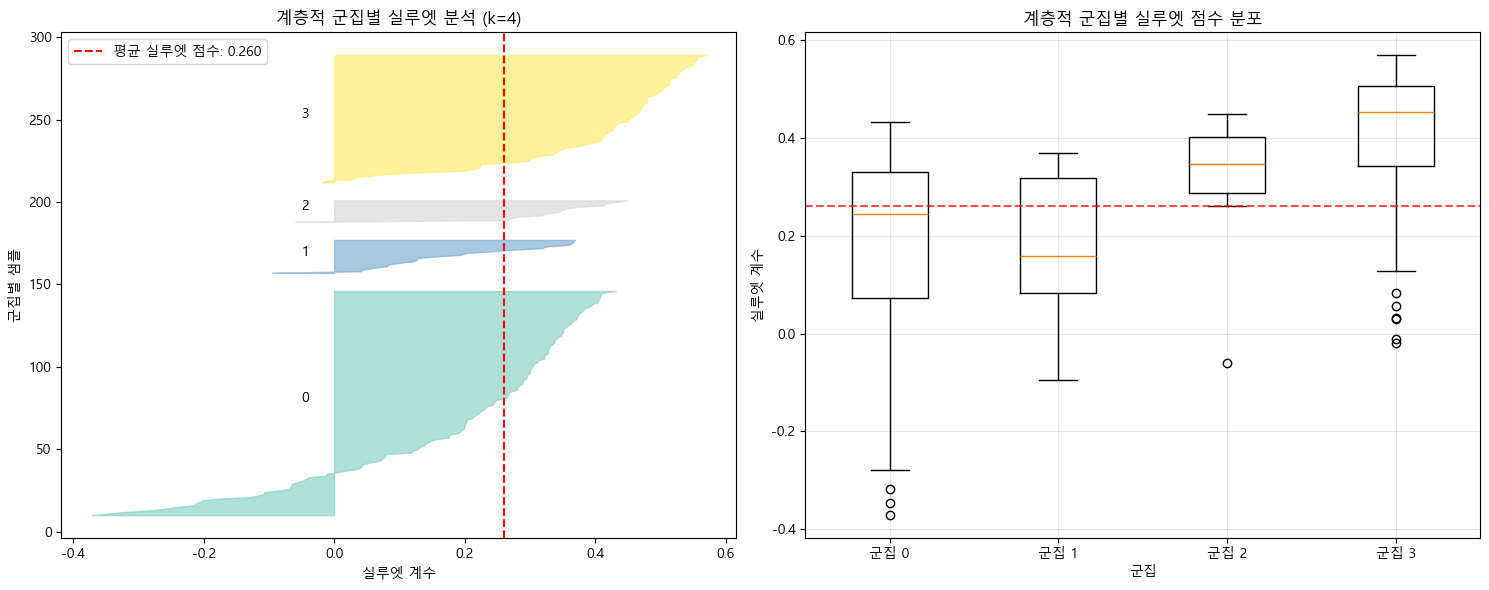


계층적 군집분석 완료!


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 계층적 군집화 Elbow Method 분석 및 시각화
def analyze_hierarchical_elbow(data, max_k=10, linkage_method='ward'):
    """계층적 군집화 Elbow Method로 최적 k 탐색"""
    k_range = range(1, max_k + 1)
    sse_values = []
    
    for k in k_range:
        if k == 1:
            # 1개 군집일 때는 전체 데이터의 중심에서의 거리
            center = np.mean(data, axis=0)
            sse = np.sum((data - center) ** 2)
        else:
            hc = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
            labels = hc.fit_predict(data)
            
            sse = 0
            for i in range(k):
                cluster_data = data[labels == i]
                if len(cluster_data) > 0:
                    cluster_center = np.mean(cluster_data, axis=0)
                    sse += np.sum((cluster_data - cluster_center) ** 2)
        
        sse_values.append(sse)
    
    # Elbow point 자동 탐지
    first_diff = np.diff(sse_values)
    second_diff = np.diff(first_diff)
    elbow_k = np.argmax(second_diff) + 2  # 인덱스 보정
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse_values, 'o-', linewidth=2, markersize=8, color='green')
    plt.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Elbow Point (k={elbow_k})')
    plt.title(f'계층적 군집화 Elbow Method 분석 ({linkage_method} linkage)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('군집 개수 (k)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"계층적 군집화 Elbow Method 최적 k: {elbow_k}")
    return elbow_k, k_range, sse_values

# 2. 계층적 군집화 실루엣 계수 분석 및 시각화
def analyze_hierarchical_silhouette(data, max_k=10, linkage_method='ward'):
    """계층적 군집화 실루엣 계수로 최적 k 탐색"""
    k_range = range(2, max_k + 1)
    silhouette_scores = []
    
    for k in k_range:
        hc = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
        labels = hc.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='orange')
    plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7,
                label=f'최적 k={optimal_k} (score={max(silhouette_scores):.3f})')
    plt.title(f'계층적 군집화 실루엣 계수 분석 ({linkage_method} linkage)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('군집 개수 (k)')
    plt.ylabel('실루엣 계수 (Silhouette Score)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"계층적 군집화 실루엣 계수 최적 k: {optimal_k}, 최고 점수: {max(silhouette_scores):.4f}")
    return optimal_k, silhouette_scores

# 3. 덴드로그램 시각화
def plot_dendrogram(data, linkage_method='ward', max_display=30):
    """계층적 군집화 덴드로그램 시각화"""
    # Linkage 계산
    if linkage_method == 'ward':
        Z = linkage(data, method='ward')
    else:
        # ward가 아닐 경우 거리 행렬 먼저 계산
        distances = pdist(data, metric='euclidean')
        Z = linkage(distances, method=linkage_method)
    
    plt.figure(figsize=(15, 8))
    
    # 덴드로그램 그리기
    dendrogram(Z, 
               truncate_mode='lastp',  # 마지막 p개 클러스터만 표시
               p=max_display,          # 표시할 최대 클러스터 수
               orientation='top',
               leaf_rotation=90,
               leaf_font_size=10)
    
    plt.title(f'계층적 군집화 덴드로그램 ({linkage_method} linkage)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('샘플 또는 군집 크기')
    plt.ylabel('거리')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    return Z

# 4. 최적 k로 계층적 군집화 수행 및 저장
def perform_hierarchical_clustering(data, k, linkage_method='ward', save_clusters=True):
    """최적 k로 계층적 군집화 수행 및 결과 저장"""
    hc = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    clusters = hc.fit_predict(data)
    
    # 군집 결과를 DataFrame에 추가
    scaled_df_with_clusters = scaled_df.copy()
    scaled_df_with_clusters['hierarchical_cluster'] = clusters
    
    if save_clusters:
        # CSV 파일로 저장
        scaled_df_with_clusters.to_csv('hierarchical_clustered_data.csv', 
                                       index=False, encoding='utf-8-sig')
        print(f"계층적 군집 결과가 'hierarchical_clustered_data.csv'에 저장되었습니다.")
    
    # 군집별 통계 정보
    print(f"\n=== 계층적 군집화 결과 (k={k}, {linkage_method} linkage) ===")
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(clusters)) * 100
        print(f"군집 {cluster_id}: {count}개 ({percentage:.1f}%)")
    
    return clusters, scaled_df_with_clusters, hc

# 5. PCA 2차원 시각화 (계층적 군집화)
def visualize_hierarchical_pca_clusters(data, clusters, k, linkage_method='ward'):
    """PCA를 사용한 계층적 군집화 2차원 시각화"""
    # PCA 수행
    pca = PCA(n_components=2, random_state=42)
    data_pca = pca.fit_transform(data)
    
    # 시각화
    plt.figure(figsize=(12, 8))
    
    # 색상 팔레트 설정
    colors = plt.cm.Set3(np.linspace(0, 1, k))
    
    for i in range(k):
        cluster_data = data_pca[clusters == i]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                   c=[colors[i]], label=f'군집 {i}', 
                   alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    plt.xlabel(f'첫 번째 주성분 (설명력: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'두 번째 주성분 (설명력: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title(f'계층적 군집화 PCA 2차원 시각화 (k={k}, {linkage_method} linkage)\n'
              f'총 설명력: {sum(pca.explained_variance_ratio_):.2%}', 
              fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPCA 설명 분산 비율:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"누적: {sum(pca.explained_variance_ratio_):.2%}")
    
    return data_pca, pca

# 6. 상세 실루엣 분석 (계층적 군집화)
def detailed_hierarchical_silhouette_analysis(data, k, linkage_method='ward'):
    """최적 k에 대한 계층적 군집화 상세 실루엣 분석"""
    hc = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
    clusters = hc.fit_predict(data)
    
    # 전체 실루엣 점수
    silhouette_avg = silhouette_score(data, clusters)
    
    # 각 샘플의 실루엣 점수
    sample_silhouette_values = silhouette_samples(data, clusters)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 실루엣 플롯
    y_lower = 10
    colors = plt.cm.Set3(np.linspace(0, 1, k))
    
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        axes[0].fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        
        axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    axes[0].set_xlabel('실루엣 계수')
    axes[0].set_ylabel('군집별 샘플')
    axes[0].set_title(f'계층적 군집별 실루엣 분석 (k={k})')
    axes[0].axvline(x=silhouette_avg, color="red", linestyle="--", 
                   label=f'평균 실루엣 점수: {silhouette_avg:.3f}')
    axes[0].legend()
    
    # 군집별 실루엣 점수 박스플롯
    silhouette_data = [sample_silhouette_values[clusters == i] for i in range(k)]
    axes[1].boxplot(silhouette_data, labels=[f'군집 {i}' for i in range(k)])
    axes[1].set_xlabel('군집')
    axes[1].set_ylabel('실루엣 계수')
    axes[1].set_title('계층적 군집별 실루엣 점수 분포')
    axes[1].axhline(y=silhouette_avg, color="red", linestyle="--", alpha=0.7)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg, sample_silhouette_values

# 7. 다양한 연결 방법 비교
def compare_linkage_methods(data, k_range=range(2, 8)):
    """다양한 연결 방법 비교"""
    linkage_methods = ['ward', 'complete', 'average', 'single']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    results = {}
    
    for idx, method in enumerate(linkage_methods):
        silhouette_scores = []
        
        for k in k_range:
            if method == 'ward':
                hc = AgglomerativeClustering(n_clusters=k, linkage=method)
            else:
                hc = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage=method)
                
            labels = hc.fit_predict(data)
            score = silhouette_score(data, labels)
            silhouette_scores.append(score)
        
        optimal_k = k_range[np.argmax(silhouette_scores)]
        results[method] = {'optimal_k': optimal_k, 'max_score': max(silhouette_scores)}
        
        # 시각화
        axes[idx].plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=6)
        axes[idx].axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7,
                         label=f'최적 k={optimal_k}')
        axes[idx].set_title(f'{method.capitalize()} Linkage')
        axes[idx].set_xlabel('군집 개수 (k)')
        axes[idx].set_ylabel('실루엣 계수')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
    
    plt.suptitle('다양한 연결 방법별 실루엣 계수 비교', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("연결 방법별 최적 결과:")
    for method, result in results.items():
        print(f"{method}: k={result['optimal_k']}, 점수={result['max_score']:.4f}")
    
    return results

# === 메인 실행 코드 ===
print("=" * 60)
print("결혼이민자 데이터 계층적 군집분석 시작")
print("=" * 60)

# 데이터 준비 (이미 scaled_df가 있다고 가정)
data = scaled_df.values
print(f"데이터 크기: {scaled_df.shape}")
print(f"특성: {list(scaled_df.columns)}")

# 1. 다양한 연결 방법 비교
print("\n1. 연결 방법별 성능 비교")
linkage_results = compare_linkage_methods(data, k_range=range(2, 10))

# 최고 성능 연결 방법 선택
best_linkage = max(linkage_results.keys(), 
                   key=lambda x: linkage_results[x]['max_score'])
best_linkage = 'ward'
print(f"\n최고 성능 연결 방법: {best_linkage}")

# 2. 덴드로그램 시각화
print(f"\n2. 덴드로그램 시각화 ({best_linkage} linkage)")
Z = plot_dendrogram(data, linkage_method=best_linkage)

# 3. Elbow Method
print(f"\n3. 계층적 군집화 Elbow Method 분석")
elbow_k, k_range, sse_values = analyze_hierarchical_elbow(data, max_k=10, 
                                                          linkage_method=best_linkage)

# 4. 실루엣 계수 분석
print(f"\n4. 계층적 군집화 실루엣 계수 분석")
silhouette_k, silhouette_scores = analyze_hierarchical_silhouette(data, max_k=10, 
                                                                  linkage_method=best_linkage)

# 5. 최종 k 결정
print(f"\n5. 최적 k 결정")
print(f"Elbow Method 추천: k={elbow_k}")
print(f"실루엣 계수 추천: k={silhouette_k}")

final_k = silhouette_k
print(f"최종 선택: k={final_k}")

# 6. 계층적 군집화 수행 및 저장
print(f"\n6. k={final_k}로 계층적 군집화 수행")
clusters, clustered_df, hc = perform_hierarchical_clustering(data, final_k, 
                                                           linkage_method=best_linkage)

# 7. PCA 2차원 시각화
print(f"\n7. PCA 2차원 시각화")
data_pca, pca = visualize_hierarchical_pca_clusters(data, clusters, final_k, 
                                                   linkage_method=best_linkage)

# 8. 상세 실루엣 분석
print(f"\n8. 상세 실루엣 분석")
silhouette_avg, sample_silhouette_values = detailed_hierarchical_silhouette_analysis(
    data, final_k, linkage_method=best_linkage)

print("\n" + "=" * 60)
print("계층적 군집분석 완료!")
print("=" * 60)


## GMM 군집화 성능 확인

결혼이민자 데이터 GMM 군집분석 시작
데이터 크기: (250, 6)
특성: ['결혼이민자 비율', '장애인구 비율', '고령인구 비율', '기초생활수급자 비율', '점포 당 인구수', 'trafic_infra']

1. 공분산 타입별 성능 비교


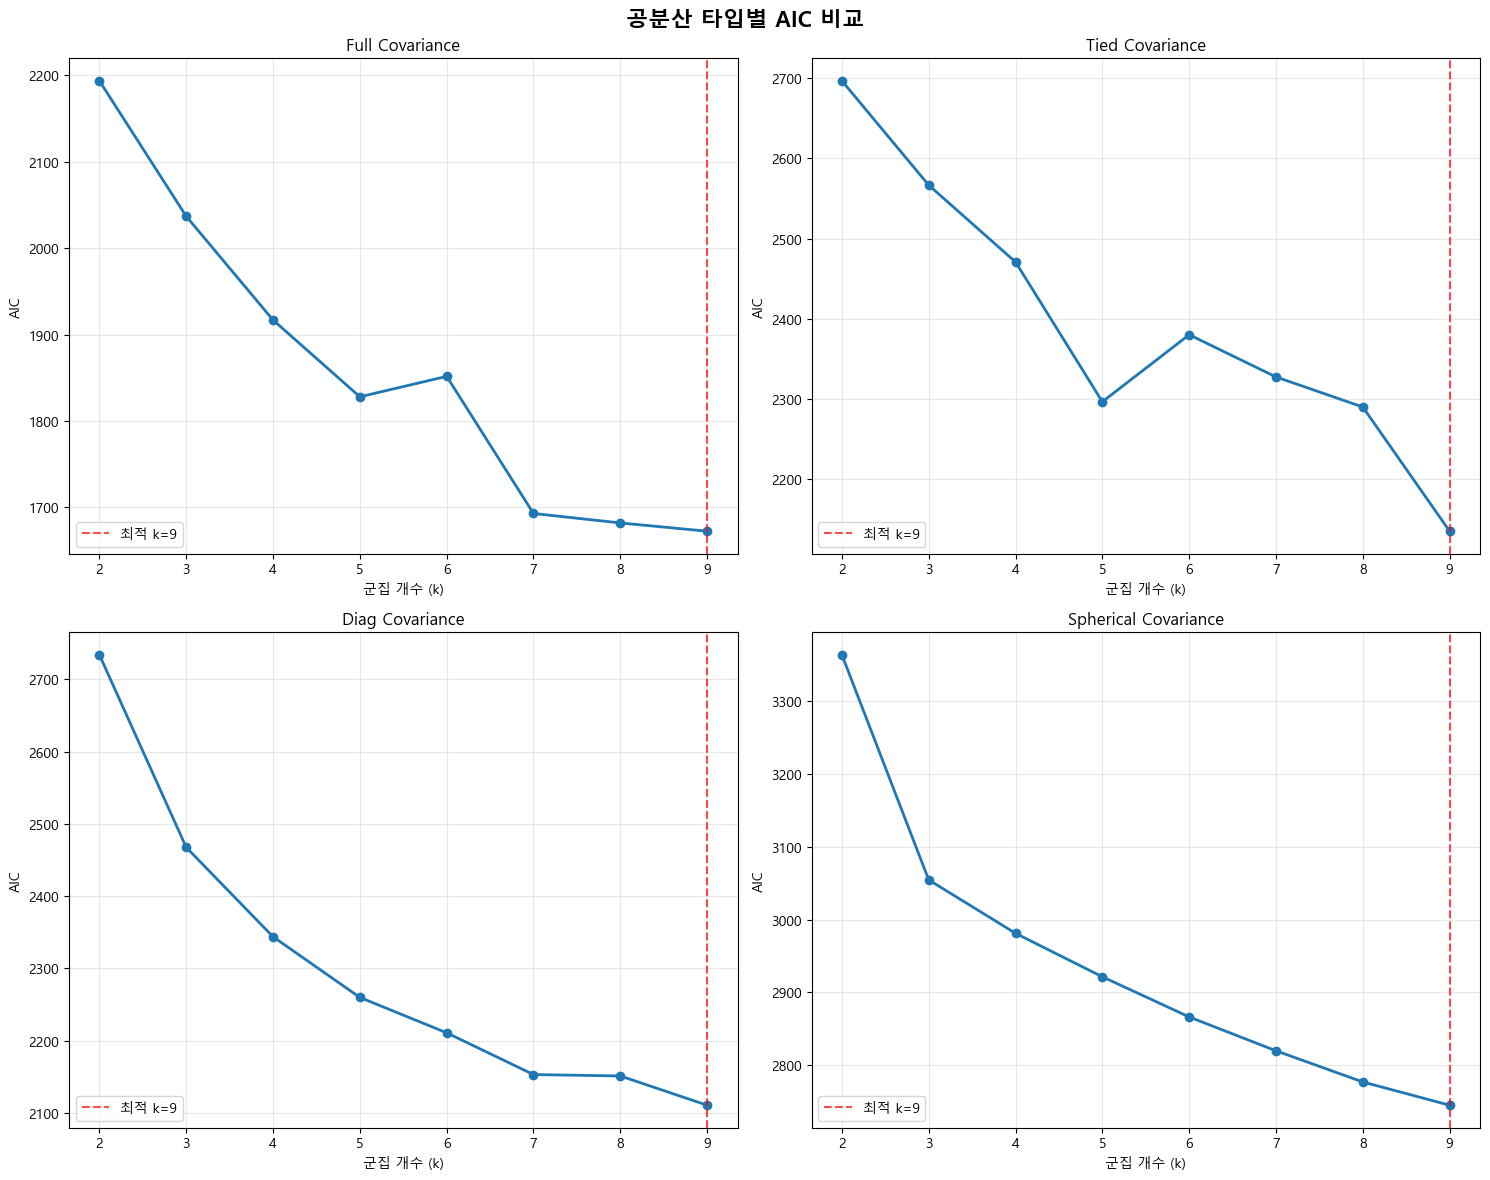

공분산 타입별 최적 결과:
full: k=9, AIC=1672.53
tied: k=9, AIC=2134.91
diag: k=9, AIC=2110.60
spherical: k=9, AIC=2744.82

최고 성능 공분산 타입: full

2. GMM AIC/BIC 분석


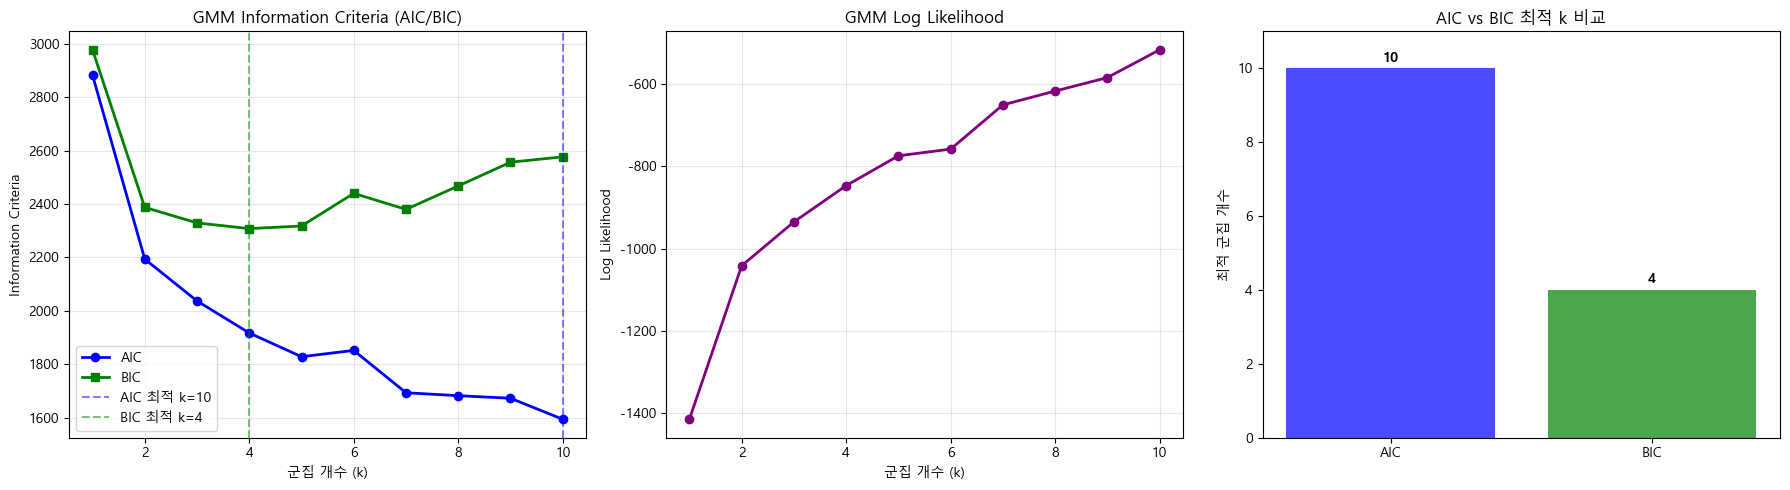

GMM AIC 최적 k: 10, AIC: 1593.86
GMM BIC 최적 k: 4, BIC: 2307.70

3. GMM Elbow Method 분석


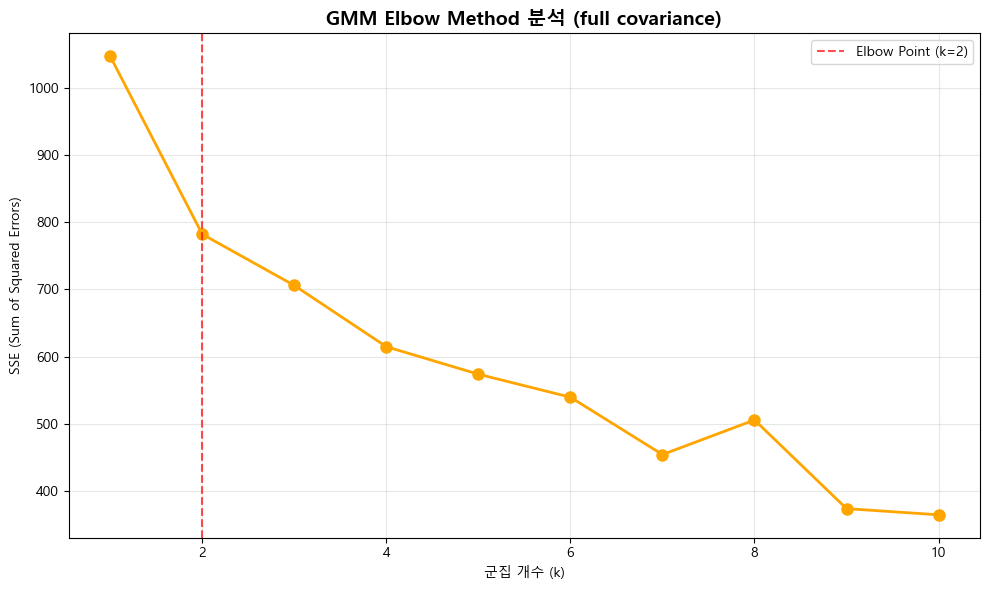

GMM Elbow Method 최적 k: 2

4. GMM 실루엣 계수 분석


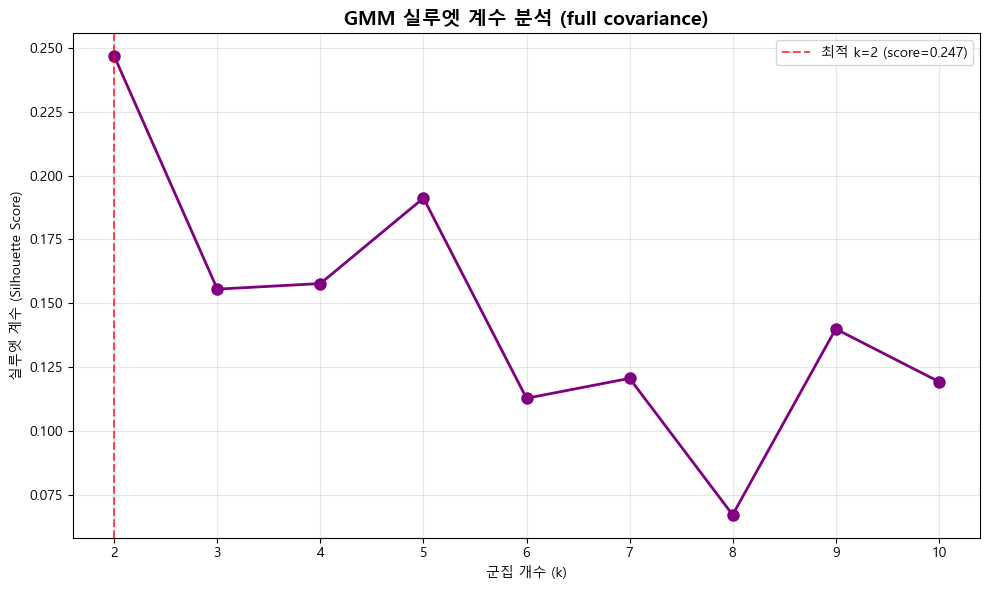

GMM 실루엣 계수 최적 k: 2, 최고 점수: 0.2467

5. 최적 k 결정
AIC 추천: k=10
BIC 추천: k=4
Elbow Method 추천: k=2
실루엣 계수 추천: k=2
최종 선택 (BIC 기준): k=4

6. k=4로 GMM 군집화 수행
GMM 군집 결과가 'gmm_clustered_data.csv'에 저장되었습니다.

=== GMM 군집화 결과 (k=4, full covariance) ===
군집 0: 66개 (26.4%)
군집 1: 39개 (15.6%)
군집 2: 46개 (18.4%)
군집 3: 99개 (39.6%)

모델 성능:
AIC: 1916.82
BIC: 2307.70
Log Likelihood: -3.3896

7. PCA 2차원 시각화


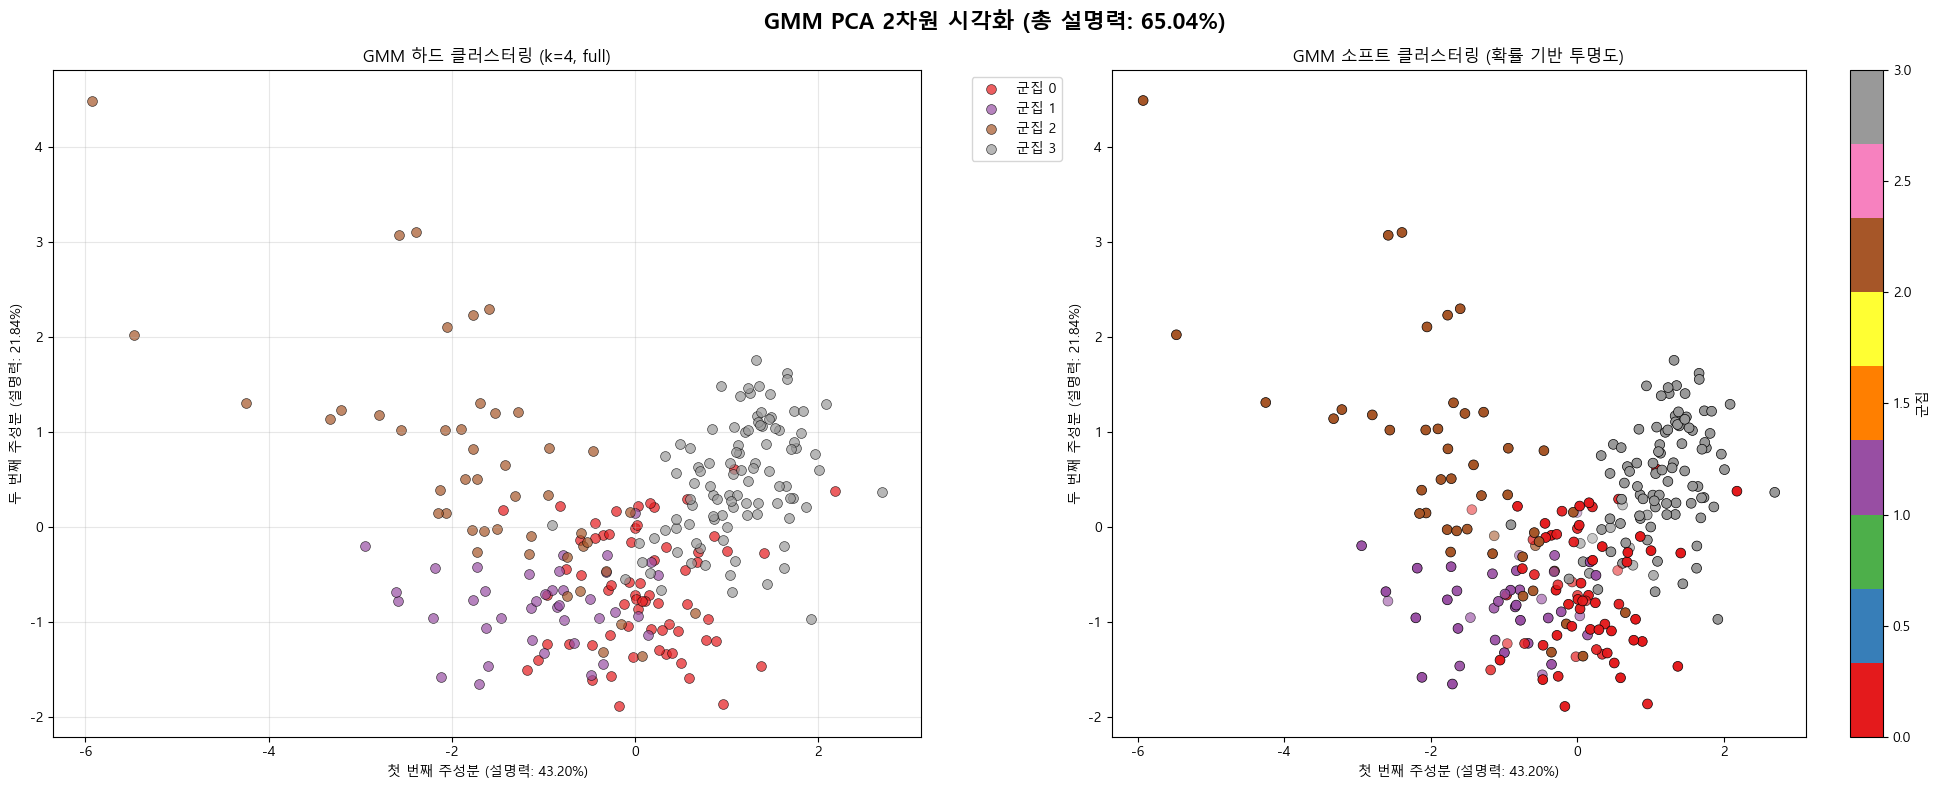


PCA 설명 분산 비율:
PC1: 43.20%
PC2: 21.84%
누적: 65.04%

8. 상세 실루엣 분석


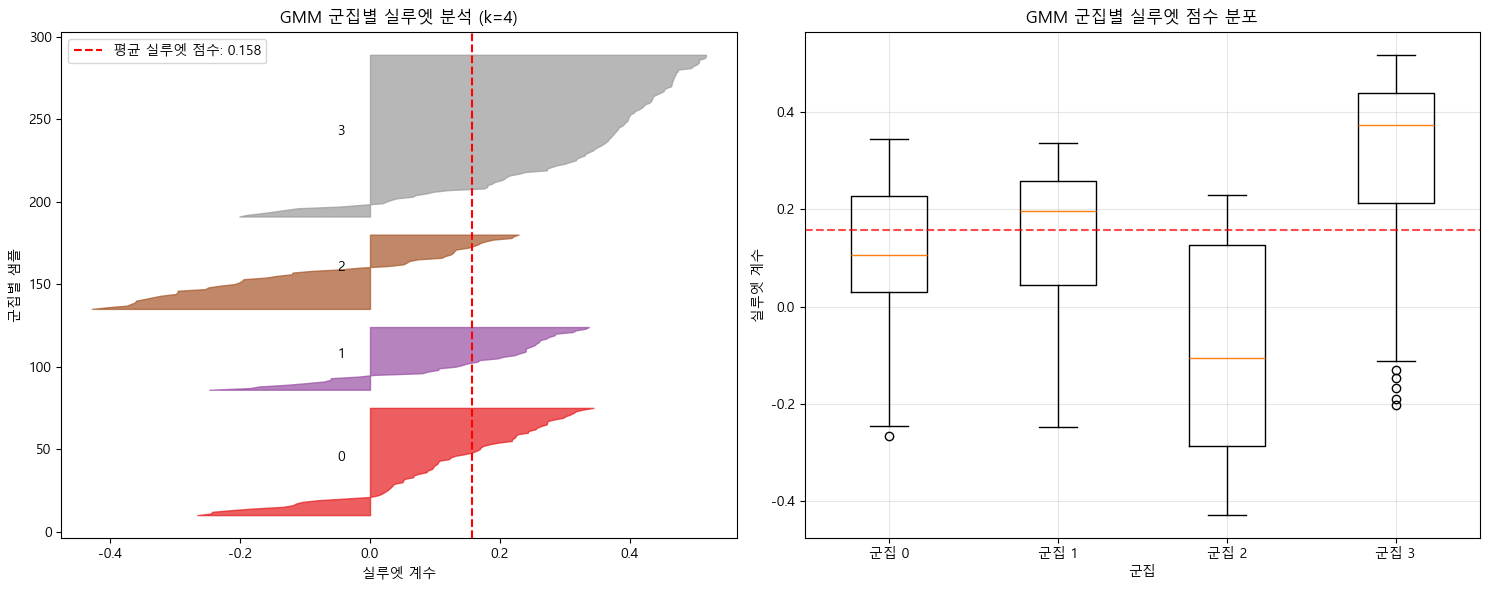


GMM 군집분석 완료!


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. GMM Elbow Method 분석 및 시각화
def analyze_gmm_elbow(data, max_k=10, covariance_type='full'):
    """GMM Elbow Method로 최적 k 탐색"""
    k_range = range(1, max_k + 1)
    sse_values = []
    
    for k in k_range:
        if k == 1:
            # 1개 군집일 때는 전체 데이터의 중심에서의 거리
            center = np.mean(data, axis=0)
            sse = np.sum((data - center) ** 2)
        else:
            gmm = GaussianMixture(n_components=k, 
                                  covariance_type=covariance_type,
                                  random_state=42,
                                  max_iter=200,
                                  n_init=5)
            gmm.fit(data)
            labels = gmm.predict(data)  # 가장 가능성 높은 군집 할당
            
            sse = 0
            for i in range(k):
                cluster_data = data[labels == i]
                if len(cluster_data) > 0:
                    cluster_center = np.mean(cluster_data, axis=0)
                    sse += np.sum((cluster_data - cluster_center) ** 2)
        
        sse_values.append(sse)
    
    # Elbow point 자동 탐지
    first_diff = np.diff(sse_values)
    second_diff = np.diff(first_diff)
    elbow_k = np.argmax(second_diff) + 2  # 인덱스 보정
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse_values, 'o-', linewidth=2, markersize=8, color='orange')
    plt.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Elbow Point (k={elbow_k})')
    plt.title(f'GMM Elbow Method 분석 ({covariance_type} covariance)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('군집 개수 (k)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"GMM Elbow Method 최적 k: {elbow_k}")
    return elbow_k, k_range, sse_values

# 2. GMM AIC/BIC 분석 (GMM에 가장 적합한 방법)
def analyze_gmm_aic_bic(data, max_k=10, covariance_type='full'):
    """GMM AIC/BIC 기반 최적 k 선정"""
    k_range = range(1, max_k + 1)
    aic_values = []
    bic_values = []
    log_likelihood_values = []
    
    for k in k_range:
        gmm = GaussianMixture(n_components=k, 
                              covariance_type=covariance_type,
                              random_state=42,
                              max_iter=200,
                              n_init=5)
        gmm.fit(data)
        aic_values.append(gmm.aic(data))
        bic_values.append(gmm.bic(data))
        log_likelihood_values.append(gmm.score(data) * len(data))  # 총 로그 가능도
    
    # 최적 k 선정 (AIC, BIC는 낮을수록 좋음)
    optimal_k_aic = k_range[np.argmin(aic_values)]
    optimal_k_bic = k_range[np.argmin(bic_values)]
    
    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # AIC/BIC 비교
    axes[0].plot(k_range, aic_values, 'o-', label='AIC', color='blue', linewidth=2)
    axes[0].plot(k_range, bic_values, 's-', label='BIC', color='green', linewidth=2)
    axes[0].axvline(x=optimal_k_aic, color='blue', linestyle='--', alpha=0.5, 
                   label=f'AIC 최적 k={optimal_k_aic}')
    axes[0].axvline(x=optimal_k_bic, color='green', linestyle='--', alpha=0.5, 
                   label=f'BIC 최적 k={optimal_k_bic}')
    axes[0].set_xlabel('군집 개수 (k)')
    axes[0].set_ylabel('Information Criteria')
    axes[0].set_title('GMM Information Criteria (AIC/BIC)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Log Likelihood
    axes[1].plot(k_range, log_likelihood_values, 'o-', color='purple', linewidth=2)
    axes[1].set_xlabel('군집 개수 (k)')
    axes[1].set_ylabel('Log Likelihood')
    axes[1].set_title('GMM Log Likelihood')
    axes[1].grid(True, alpha=0.3)
    
    # AIC vs BIC 비교 막대 그래프
    methods = ['AIC', 'BIC']
    optimal_ks = [optimal_k_aic, optimal_k_bic]
    colors = ['blue', 'green']
    
    bars = axes[2].bar(methods, optimal_ks, color=colors, alpha=0.7)
    axes[2].set_ylabel('최적 군집 개수')
    axes[2].set_title('AIC vs BIC 최적 k 비교')
    axes[2].set_ylim([0, max(optimal_ks) + 1])
    
    # 값 표시
    for bar, k in zip(bars, optimal_ks):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(k)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"GMM AIC 최적 k: {optimal_k_aic}, AIC: {min(aic_values):.2f}")
    print(f"GMM BIC 최적 k: {optimal_k_bic}, BIC: {min(bic_values):.2f}")
    
    return optimal_k_aic, optimal_k_bic, aic_values, bic_values

# 3. GMM 실루엣 계수 분석
def analyze_gmm_silhouette(data, max_k=10, covariance_type='full'):
    """GMM 실루엣 계수로 최적 k 탐색"""
    k_range = range(2, max_k + 1)
    silhouette_scores = []
    
    for k in k_range:
        gmm = GaussianMixture(n_components=k, 
                              covariance_type=covariance_type,
                              random_state=42,
                              max_iter=200,
                              n_init=5)
        labels = gmm.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='purple')
    plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7,
                label=f'최적 k={optimal_k} (score={max(silhouette_scores):.3f})')
    plt.title(f'GMM 실루엣 계수 분석 ({covariance_type} covariance)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('군집 개수 (k)')
    plt.ylabel('실루엣 계수 (Silhouette Score)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"GMM 실루엣 계수 최적 k: {optimal_k}, 최고 점수: {max(silhouette_scores):.4f}")
    return optimal_k, silhouette_scores

# 4. 공분산 타입별 비교
def compare_covariance_types(data, k_range=range(2, 8)):
    """다양한 공분산 타입 비교"""
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    results = {}
    
    for idx, cov_type in enumerate(covariance_types):
        aic_values = []
        
        for k in k_range:
            try:
                gmm = GaussianMixture(n_components=k, 
                                      covariance_type=cov_type,
                                      random_state=42,
                                      max_iter=200,
                                      n_init=5)
                gmm.fit(data)
                aic_values.append(gmm.aic(data))
            except:
                aic_values.append(np.inf)
        
        optimal_k = k_range[np.argmin(aic_values)]
        results[cov_type] = {'optimal_k': optimal_k, 'min_aic': min(aic_values)}
        
        # 시각화
        axes[idx].plot(k_range, aic_values, 'o-', linewidth=2, markersize=6)
        axes[idx].axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7,
                         label=f'최적 k={optimal_k}')
        axes[idx].set_title(f'{cov_type.capitalize()} Covariance')
        axes[idx].set_xlabel('군집 개수 (k)')
        axes[idx].set_ylabel('AIC')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
    
    plt.suptitle('공분산 타입별 AIC 비교', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("공분산 타입별 최적 결과:")
    for cov_type, result in results.items():
        print(f"{cov_type}: k={result['optimal_k']}, AIC={result['min_aic']:.2f}")
    
    return results

# 5. 최적 k로 GMM 군집화 수행 및 저장
def perform_gmm_clustering(data, k, covariance_type='full', save_clusters=True):
    """최적 k로 GMM 군집화 수행 및 결과 저장"""
    gmm = GaussianMixture(n_components=k, 
                          covariance_type=covariance_type,
                          random_state=42,
                          max_iter=200,
                          n_init=5)
    
    gmm.fit(data)
    clusters = gmm.predict(data)
    probabilities = gmm.predict_proba(data)
    
    # 군집 결과를 DataFrame에 추가
    scaled_df_with_clusters = scaled_df.copy()
    scaled_df_with_clusters['gmm_cluster'] = clusters
    
    # 각 군집에 대한 확률도 추가
    for i in range(k):
        scaled_df_with_clusters[f'cluster_{i}_prob'] = probabilities[:, i]
    
    if save_clusters:
        # CSV 파일로 저장
        scaled_df_with_clusters.to_csv('gmm_clustered_data.csv', 
                                       index=False, encoding='utf-8-sig')
        print(f"GMM 군집 결과가 'gmm_clustered_data.csv'에 저장되었습니다.")
    
    # 군집별 통계 정보
    print(f"\n=== GMM 군집화 결과 (k={k}, {covariance_type} covariance) ===")
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(clusters)) * 100
        print(f"군집 {cluster_id}: {count}개 ({percentage:.1f}%)")
    
    # 모델 성능 정보
    print(f"\n모델 성능:")
    print(f"AIC: {gmm.aic(data):.2f}")
    print(f"BIC: {gmm.bic(data):.2f}")
    print(f"Log Likelihood: {gmm.score(data):.4f}")
    
    return clusters, probabilities, scaled_df_with_clusters, gmm

# 6. PCA 2차원 시각화 (GMM)
def visualize_gmm_pca_clusters(data, clusters, probabilities, k, covariance_type='full'):
    """PCA를 사용한 GMM 군집화 2차원 시각화"""
    # PCA 수행
    pca = PCA(n_components=2, random_state=42)
    data_pca = pca.fit_transform(data)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. 하드 클러스터링 결과
    colors = plt.cm.Set1(np.linspace(0, 1, k))
    
    for i in range(k):
        cluster_data = data_pca[clusters == i]
        axes[0].scatter(cluster_data[:, 0], cluster_data[:, 1], 
                       c=[colors[i]], label=f'군집 {i}', 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    axes[0].set_xlabel(f'첫 번째 주성분 (설명력: {pca.explained_variance_ratio_[0]:.2%})')
    axes[0].set_ylabel(f'두 번째 주성분 (설명력: {pca.explained_variance_ratio_[1]:.2%})')
    axes[0].set_title(f'GMM 하드 클러스터링 (k={k}, {covariance_type})')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # 2. 소프트 클러스터링 결과 (확률 기반)
    # 가장 높은 확률을 가진 군집의 확률로 투명도 조절
    max_probs = np.max(probabilities, axis=1)
    
    scatter = axes[1].scatter(data_pca[:, 0], data_pca[:, 1], 
                             c=clusters, cmap='Set1', 
                             alpha=max_probs, s=50, 
                             edgecolors='black', linewidth=0.5)
    
    axes[1].set_xlabel(f'첫 번째 주성분 (설명력: {pca.explained_variance_ratio_[0]:.2%})')
    axes[1].set_ylabel(f'두 번째 주성분 (설명력: {pca.explained_variance_ratio_[1]:.2%})')
    axes[1].set_title(f'GMM 소프트 클러스터링 (확률 기반 투명도)')
    
    # 컬러바 추가
    cbar = plt.colorbar(scatter, ax=axes[1])
    cbar.set_label('군집')
    
    plt.suptitle(f'GMM PCA 2차원 시각화 (총 설명력: {sum(pca.explained_variance_ratio_):.2%})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nPCA 설명 분산 비율:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"누적: {sum(pca.explained_variance_ratio_):.2%}")
    
    return data_pca, pca

# 7. 상세 실루엣 분석 (GMM)
def detailed_gmm_silhouette_analysis(data, k, covariance_type='full'):
    """최적 k에 대한 GMM 상세 실루엣 분석"""
    gmm = GaussianMixture(n_components=k, 
                          covariance_type=covariance_type,
                          random_state=42,
                          max_iter=200,
                          n_init=5)
    clusters = gmm.fit_predict(data)
    
    # 전체 실루엣 점수
    silhouette_avg = silhouette_score(data, clusters)
    
    # 각 샘플의 실루엣 점수
    sample_silhouette_values = silhouette_samples(data, clusters)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 실루엣 플롯
    y_lower = 10
    colors = plt.cm.Set1(np.linspace(0, 1, k))
    
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        axes[0].fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        
        axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    axes[0].set_xlabel('실루엣 계수')
    axes[0].set_ylabel('군집별 샘플')
    axes[0].set_title(f'GMM 군집별 실루엣 분석 (k={k})')
    axes[0].axvline(x=silhouette_avg, color="red", linestyle="--", 
                   label=f'평균 실루엣 점수: {silhouette_avg:.3f}')
    axes[0].legend()
    
    # 군집별 실루엣 점수 박스플롯
    silhouette_data = [sample_silhouette_values[clusters == i] for i in range(k)]
    axes[1].boxplot(silhouette_data, labels=[f'군집 {i}' for i in range(k)])
    axes[1].set_xlabel('군집')
    axes[1].set_ylabel('실루엣 계수')
    axes[1].set_title('GMM 군집별 실루엣 점수 분포')
    axes[1].axhline(y=silhouette_avg, color="red", linestyle="--", alpha=0.7)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg, sample_silhouette_values

# === 메인 실행 코드 ===
print("=" * 60)
print("결혼이민자 데이터 GMM 군집분석 시작")
print("=" * 60)

# 데이터 준비 (이미 scaled_df가 있다고 가정)
data = scaled_df.values
print(f"데이터 크기: {scaled_df.shape}")
print(f"특성: {list(scaled_df.columns)}")

# 1. 공분산 타입별 성능 비교
print("\n1. 공분산 타입별 성능 비교")
covariance_results = compare_covariance_types(data, k_range=range(2, 10))

# 최고 성능 공분산 타입 선택
best_covariance = min(covariance_results.keys(), 
                      key=lambda x: covariance_results[x]['min_aic'])
print(f"\n최고 성능 공분산 타입: {best_covariance}")

# 2. AIC/BIC 분석 (GMM의 표준 방법)
print(f"\n2. GMM AIC/BIC 분석")
aic_k, bic_k, aic_values, bic_values = analyze_gmm_aic_bic(data, max_k=10, 
                                                           covariance_type=best_covariance)

# 3. Elbow Method
print(f"\n3. GMM Elbow Method 분석")
elbow_k, k_range, sse_values = analyze_gmm_elbow(data, max_k=10, 
                                                 covariance_type=best_covariance)

# 4. 실루엣 계수 분석
print(f"\n4. GMM 실루엣 계수 분석")
silhouette_k, silhouette_scores = analyze_gmm_silhouette(data, max_k=10, 
                                                        covariance_type=best_covariance)

# 5. 최종 k 결정
print(f"\n5. 최적 k 결정")
print(f"AIC 추천: k={aic_k}")
print(f"BIC 추천: k={bic_k}")
print(f"Elbow Method 추천: k={elbow_k}")
print(f"실루엣 계수 추천: k={silhouette_k}")

# BIC를 우선적으로 사용 (GMM에서 일반적으로 더 보수적이고 신뢰할만함)
final_k = bic_k
print(f"최종 선택 (BIC 기준): k={final_k}")

# 6. GMM 군집화 수행 및 저장
print(f"\n6. k={final_k}로 GMM 군집화 수행")
clusters, probabilities, clustered_df, gmm = perform_gmm_clustering(
    data, final_k, covariance_type=best_covariance)

# 7. PCA 2차원 시각화
print(f"\n7. PCA 2차원 시각화")
data_pca, pca = visualize_gmm_pca_clusters(data, clusters, probabilities, final_k, 
                                          covariance_type=best_covariance)

# 8. 상세 실루엣 분석
print(f"\n8. 상세 실루엣 분석")
silhouette_avg, sample_silhouette_values = detailed_gmm_silhouette_analysis(
    data, final_k, covariance_type=best_covariance)

print("\n" + "=" * 60)
print("GMM 군집분석 완료!")
print("=" * 60)


## Mean Shift 군집화 성능 확인

결혼이민자 데이터 Mean Shift 군집분석 시작
데이터 크기: (250, 6)
특성: ['결혼이민자 비율', '장애인구 비율', '고령인구 비율', '기초생활수급자 비율', '점포 당 인구수', 'trafic_infra']

1. Bandwidth 추정 방법 비교


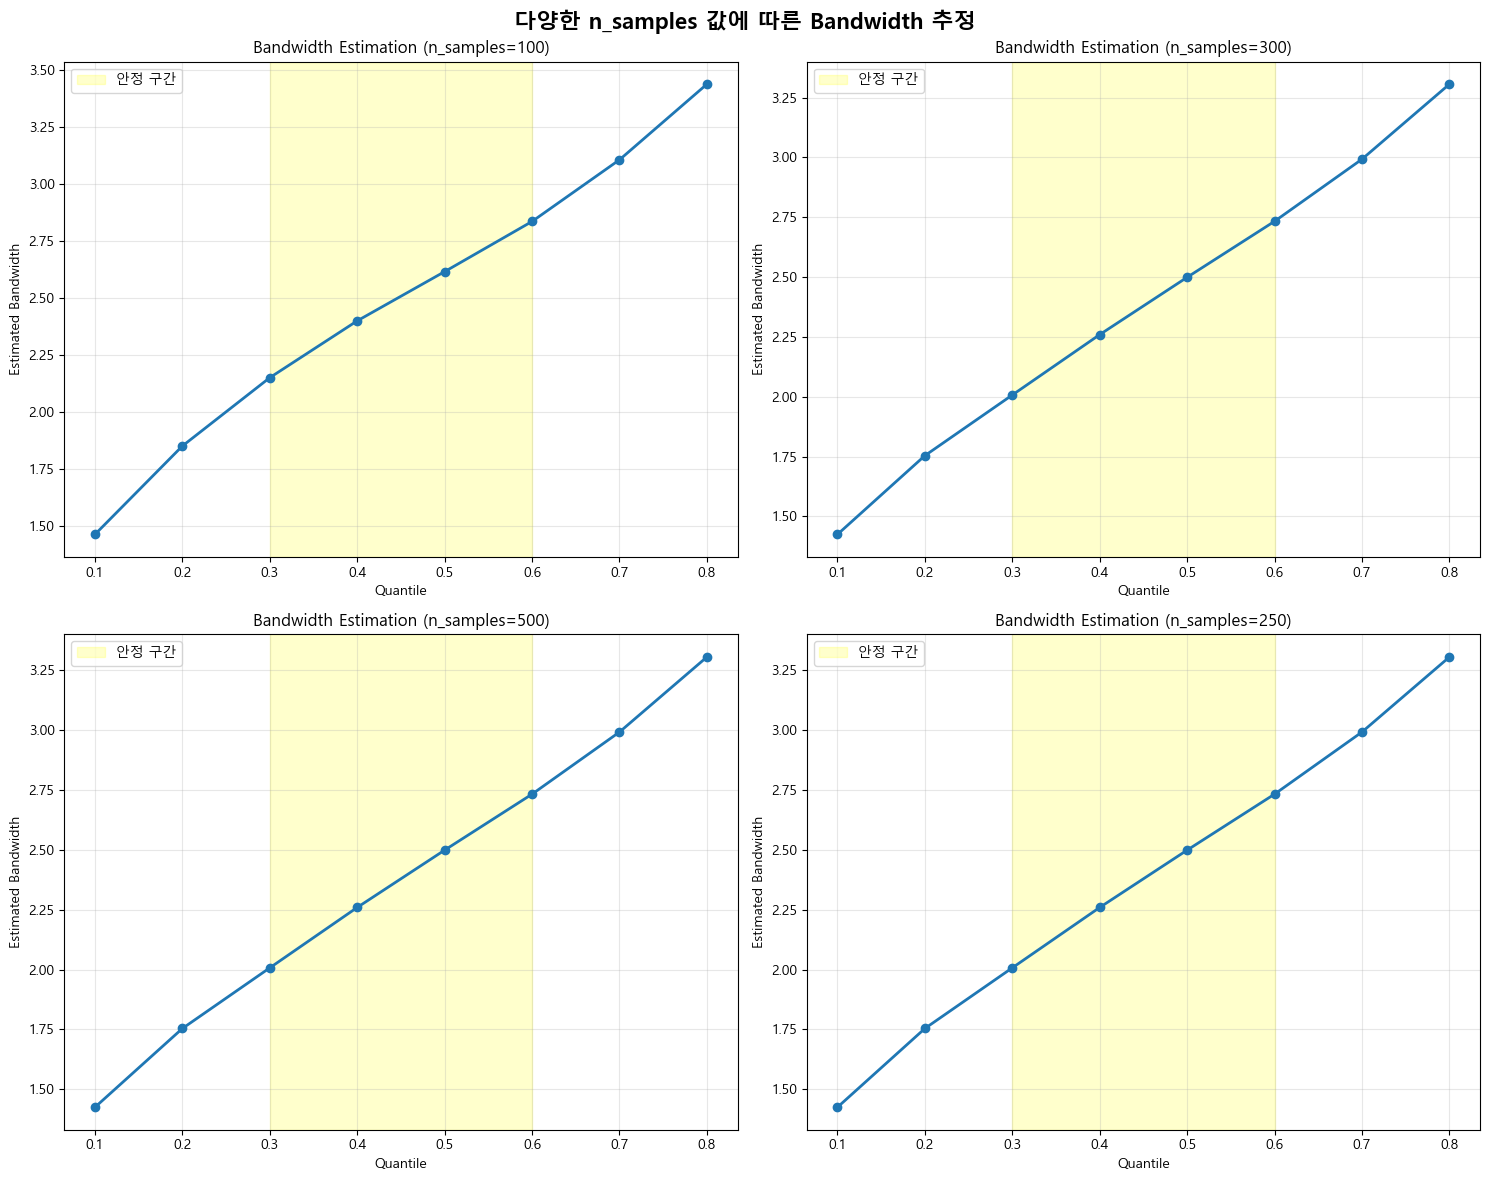


2. Mean Shift bandwidth 성능 분석
Quantile 기반 bandwidth 분석 중...
직접 bandwidth 지정 분석 중...


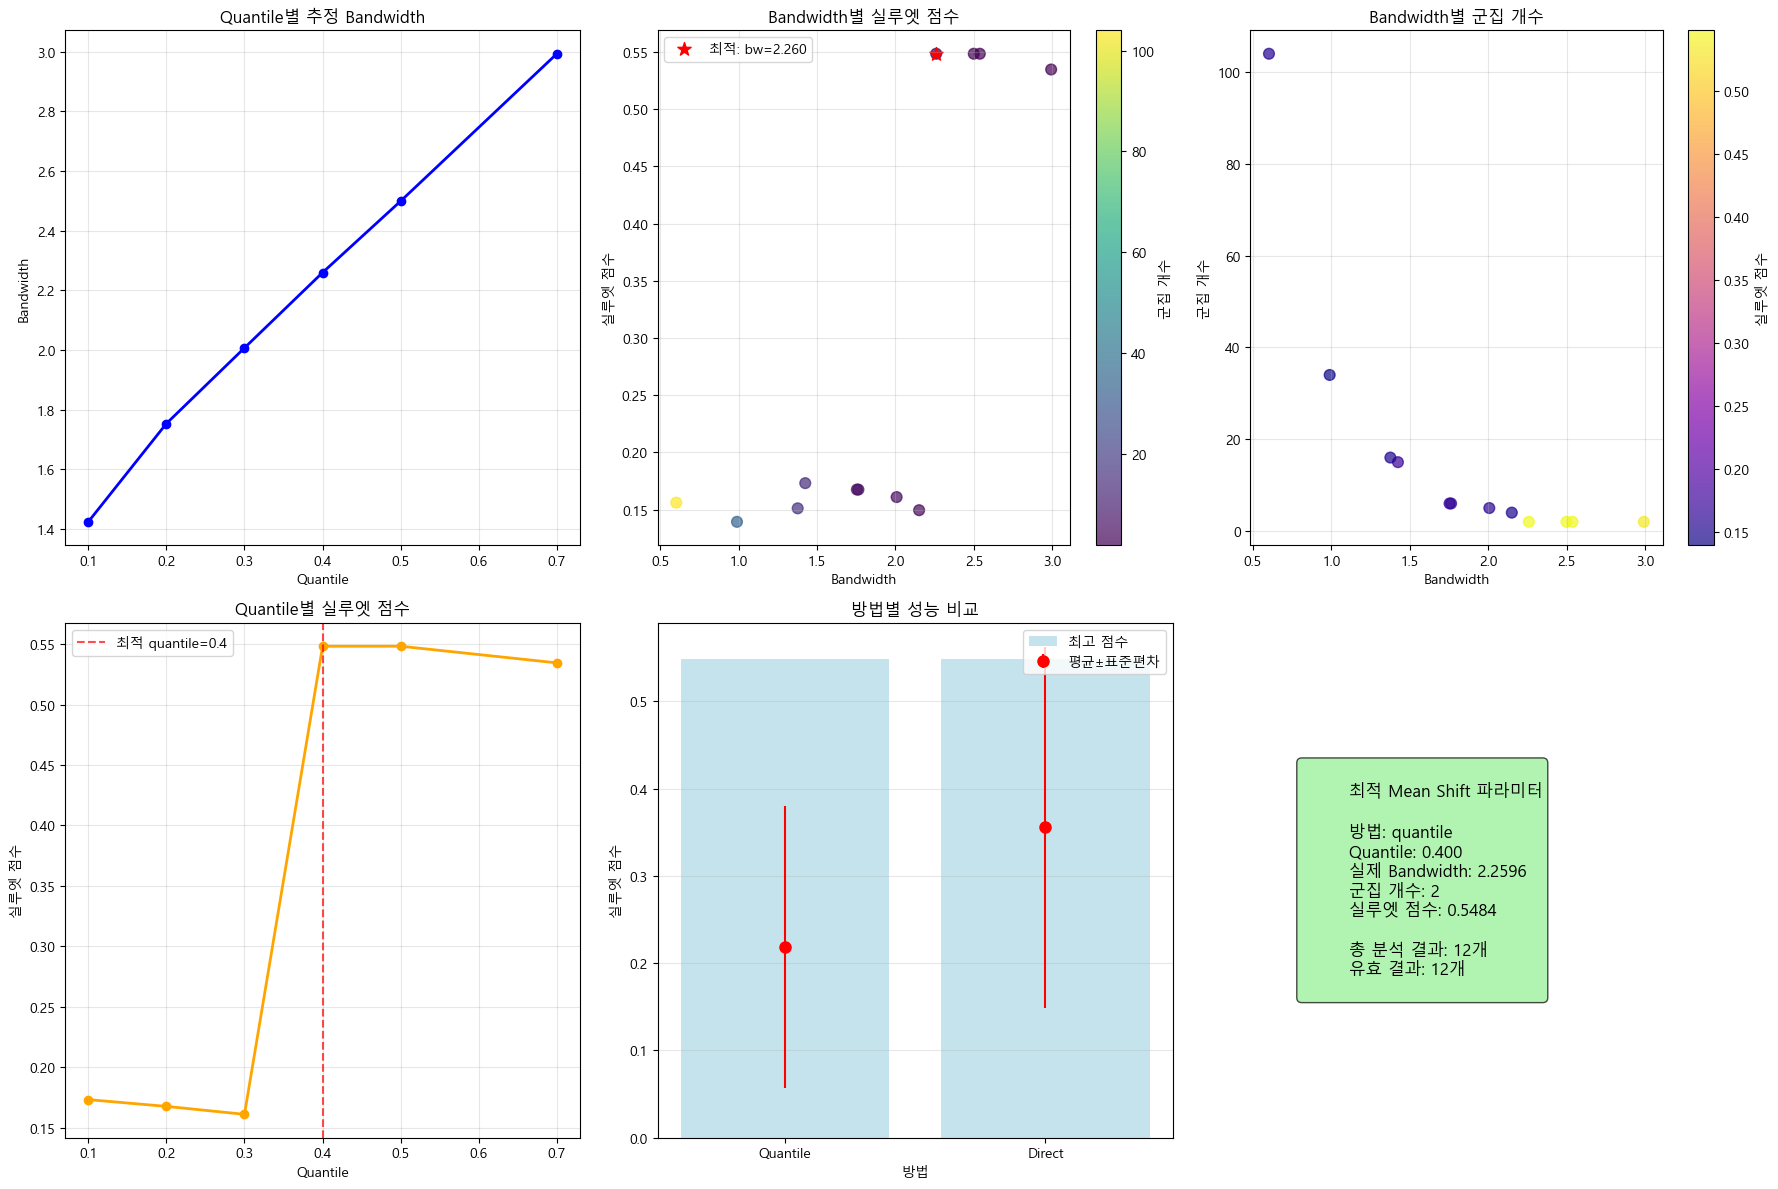


3. 최적 Mean Shift 파라미터
방법: quantile
Quantile: 0.400
실제 Bandwidth: 2.2596
예상 군집 수: 2
실루엣 점수: 0.5484

4. 최적 파라미터로 Mean Shift 수행
Mean Shift 군집 결과가 'meanshift_clustered_data.csv'에 저장되었습니다.

=== Mean Shift 군집화 결과 (bandwidth=2.2596) ===
총 군집 개수: 2
클러스터 중심점 개수: 2
군집 0: 245개 (98.0%), 평균 중심거리: 1.7488
군집 1: 5개 (2.0%), 평균 중심거리: 3.0047

5. PCA 2차원 시각화


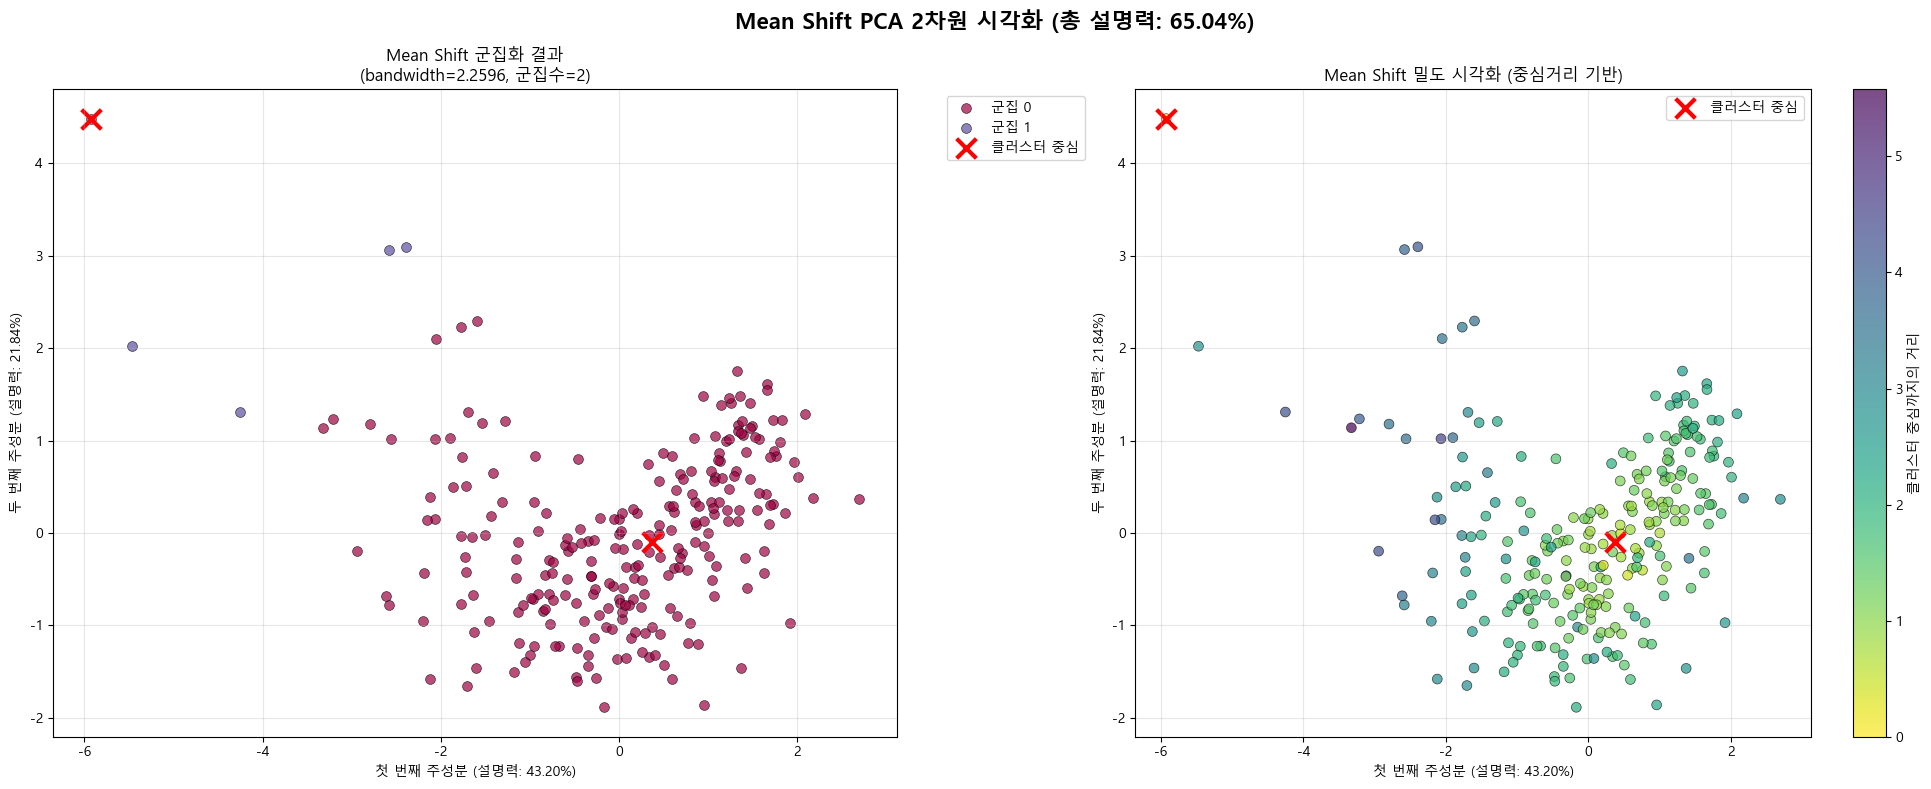


PCA 설명 분산 비율:
PC1: 43.20%
PC2: 21.84%
누적: 65.04%

6. 상세 실루엣 분석


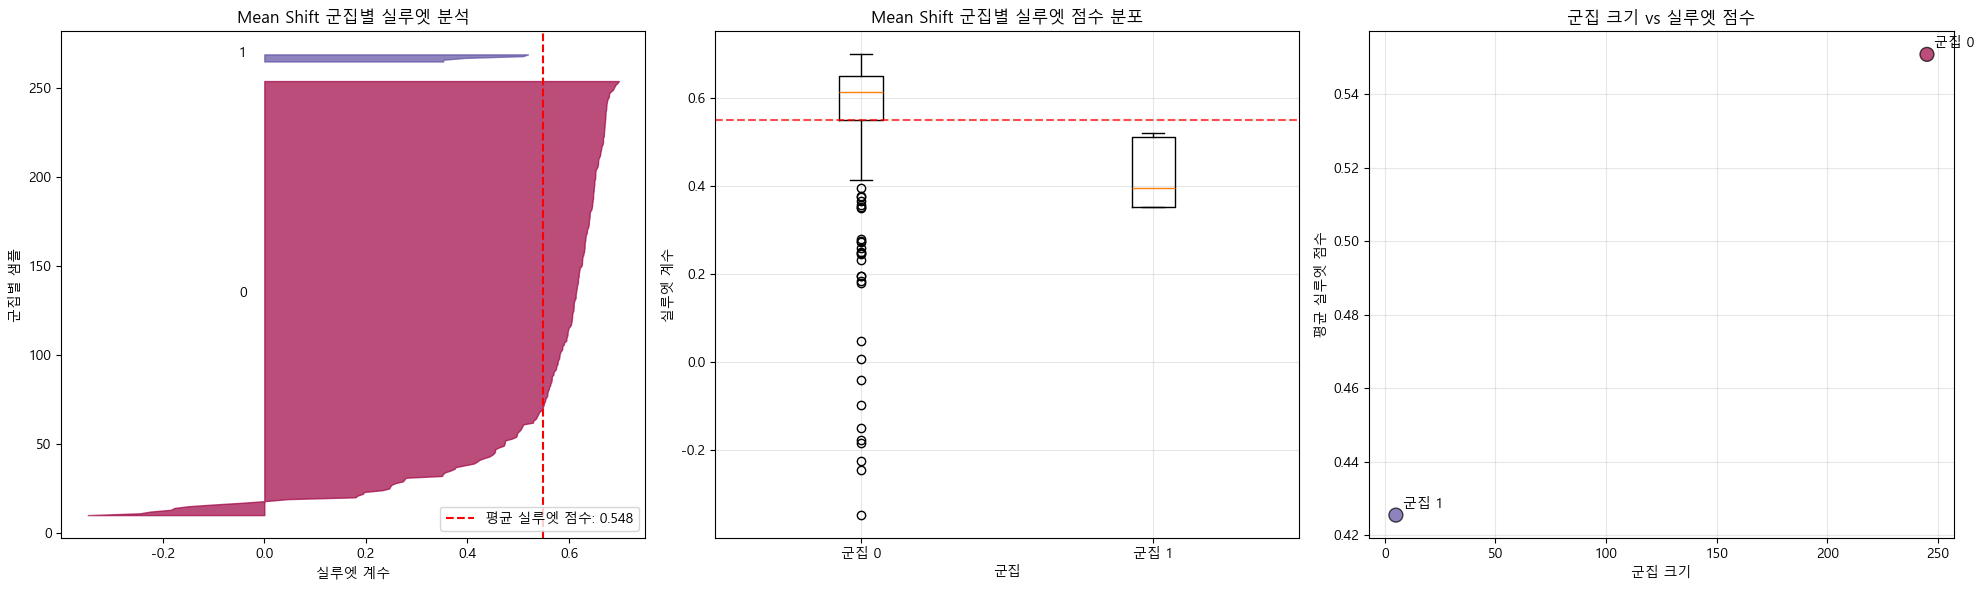


7. Bandwidth 민감도 분석


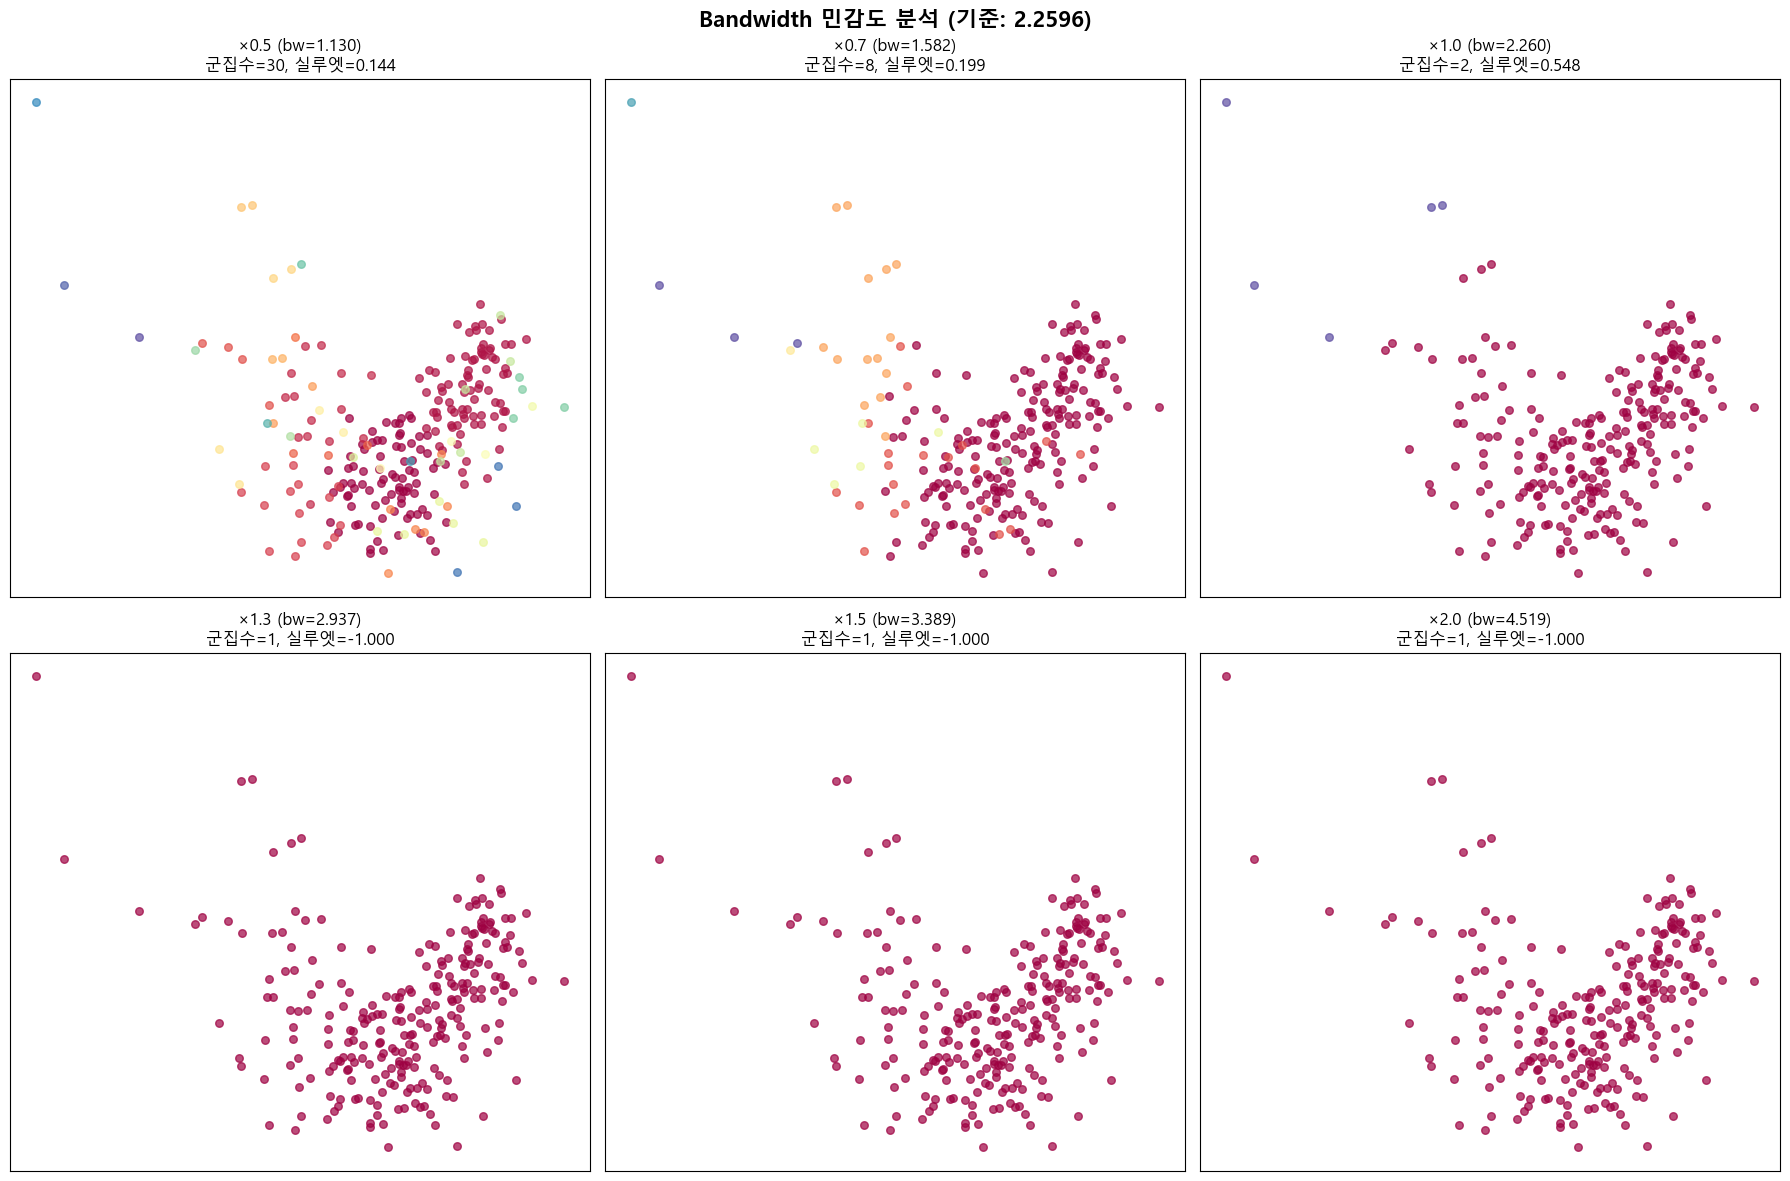

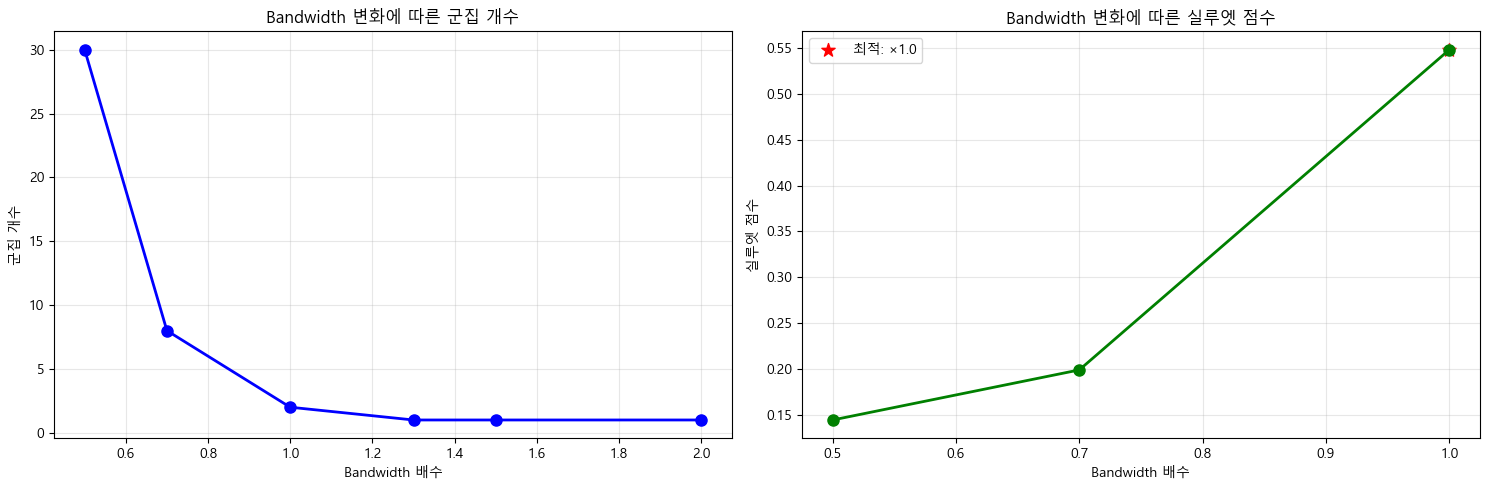


Mean Shift 군집분석 완료!


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. Bandwidth 추정 방법 비교
def compare_bandwidth_estimation_methods(data, n_samples_range=[100, 300, 500, 1000]):
    """다양한 방법으로 bandwidth 추정 비교"""
    quantile_range = np.arange(0.1, 0.9, 0.1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    all_bandwidths = {}
    
    for idx, n_samples in enumerate(n_samples_range):
        bandwidths = []
        
        for quantile in quantile_range:
            try:
                # n_samples가 데이터 크기보다 크면 전체 데이터 사용
                actual_n_samples = min(n_samples, len(data))
                bandwidth = estimate_bandwidth(data, quantile=quantile, 
                                             n_samples=actual_n_samples)
                bandwidths.append(bandwidth)
            except:
                bandwidths.append(np.nan)
        
        all_bandwidths[n_samples] = bandwidths
        
        # 시각화
        axes[idx].plot(quantile_range, bandwidths, 'o-', linewidth=2, markersize=6)
        axes[idx].set_xlabel('Quantile')
        axes[idx].set_ylabel('Estimated Bandwidth')
        axes[idx].set_title(f'Bandwidth Estimation (n_samples={n_samples})')
        axes[idx].grid(True, alpha=0.3)
        
        # 안정적인 구간 표시 (중간값들)
        if not np.isnan(bandwidths).all():
            stable_range = quantile_range[2:6]  # 0.3 ~ 0.6
            stable_bandwidths = bandwidths[2:6]
            axes[idx].axvspan(stable_range[0], stable_range[-1], alpha=0.2, color='yellow',
                             label='안정 구간')
            axes[idx].legend()
    
    plt.suptitle('다양한 n_samples 값에 따른 Bandwidth 추정', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return all_bandwidths

# 2. Mean Shift bandwidth 범위별 성능 분석
def analyze_meanshift_bandwidth_range(data, bandwidth_range=None, quantile_range=None):
    """Mean Shift bandwidth 파라미터별 성능 시각화"""
    if quantile_range is None:
        quantile_range = np.arange(0.1, 0.9, 0.1)
    
    if bandwidth_range is None:
        # 자동으로 bandwidth 범위 생성
        base_bandwidth = estimate_bandwidth(data, quantile=0.3, n_samples=500)
        bandwidth_range = np.linspace(base_bandwidth * 0.3, base_bandwidth * 3.0, 15)
    
    results = []
    best_score = -1
    best_params = {}
    
    # Quantile 기반 분석
    print("Quantile 기반 bandwidth 분석 중...")
    for quantile in quantile_range:
        try:
            bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=500)
            
            if bandwidth > 0:
                ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
                labels = ms.fit_predict(data)
                
                n_clusters = len(set(labels))
                cluster_centers = ms.cluster_centers_
                
                if n_clusters > 1:
                    score = silhouette_score(data, labels)
                    results.append({
                        'method': 'quantile',
                        'parameter': quantile,
                        'bandwidth': bandwidth,
                        'n_clusters': n_clusters,
                        'silhouette_score': score,
                        'n_centers': len(cluster_centers)
                    })
                    
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'method': 'quantile',
                            'parameter': quantile,
                            'bandwidth': bandwidth,
                            'n_clusters': n_clusters,
                            'silhouette_score': score
                        }
        except Exception as e:
            continue
    
    # 직접 bandwidth 지정 분석
    print("직접 bandwidth 지정 분석 중...")
    for bandwidth in bandwidth_range:
        try:
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            labels = ms.fit_predict(data)
            
            n_clusters = len(set(labels))
            cluster_centers = ms.cluster_centers_
            
            if n_clusters > 1:
                score = silhouette_score(data, labels)
                results.append({
                    'method': 'direct',
                    'parameter': bandwidth,
                    'bandwidth': bandwidth,
                    'n_clusters': n_clusters,
                    'silhouette_score': score,
                    'n_centers': len(cluster_centers)
                })
                
                if score > best_score:
                    best_score = score
                    best_params = {
                        'method': 'direct',
                        'parameter': bandwidth,
                        'bandwidth': bandwidth,
                        'n_clusters': n_clusters,
                        'silhouette_score': score
                    }
        except Exception as e:
            continue
    
    if not results:
        print("경고: 유효한 Mean Shift 결과를 얻을 수 없습니다.")
        return None, None
    
    results_df = pd.DataFrame(results)
    
    # 시각화
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Quantile vs Bandwidth
    quantile_results = results_df[results_df['method'] == 'quantile']
    if not quantile_results.empty:
        axes[0, 0].plot(quantile_results['parameter'], quantile_results['bandwidth'], 
                       'o-', linewidth=2, markersize=6, color='blue')
        axes[0, 0].set_xlabel('Quantile')
        axes[0, 0].set_ylabel('Bandwidth')
        axes[0, 0].set_title('Quantile별 추정 Bandwidth')
        axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Bandwidth vs 실루엣 점수 (전체)
    axes[0, 1].scatter(results_df['bandwidth'], results_df['silhouette_score'], 
                      c=results_df['n_clusters'], cmap='viridis', s=60, alpha=0.7)
    if best_params:
        axes[0, 1].scatter(best_params['bandwidth'], best_params['silhouette_score'], 
                          c='red', s=100, marker='*', 
                          label=f'최적: bw={best_params["bandwidth"]:.3f}')
        axes[0, 1].legend()
    axes[0, 1].set_xlabel('Bandwidth')
    axes[0, 1].set_ylabel('실루엣 점수')
    axes[0, 1].set_title('Bandwidth별 실루엣 점수')
    cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
    cbar.set_label('군집 개수')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Bandwidth vs 군집 개수
    axes[0, 2].scatter(results_df['bandwidth'], results_df['n_clusters'], 
                      c=results_df['silhouette_score'], cmap='plasma', s=60, alpha=0.7)
    axes[0, 2].set_xlabel('Bandwidth')
    axes[0, 2].set_ylabel('군집 개수')
    axes[0, 2].set_title('Bandwidth별 군집 개수')
    cbar = plt.colorbar(axes[0, 2].collections[0], ax=axes[0, 2])
    cbar.set_label('실루엣 점수')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Quantile별 실루엣 점수
    if not quantile_results.empty:
        axes[1, 0].plot(quantile_results['parameter'], quantile_results['silhouette_score'], 
                       'o-', linewidth=2, markersize=6, color='orange')
        best_quantile_idx = quantile_results['silhouette_score'].idxmax()
        best_quantile_row = quantile_results.loc[best_quantile_idx]
        axes[1, 0].axvline(x=best_quantile_row['parameter'], color='red', 
                          linestyle='--', alpha=0.7,
                          label=f'최적 quantile={best_quantile_row["parameter"]:.1f}')
        axes[1, 0].set_xlabel('Quantile')
        axes[1, 0].set_ylabel('실루엣 점수')
        axes[1, 0].set_title('Quantile별 실루엣 점수')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. 방법별 성능 비교
    method_comparison = results_df.groupby('method')['silhouette_score'].agg(['max', 'mean', 'std'])
    methods = method_comparison.index
    max_scores = method_comparison['max'].values
    mean_scores = method_comparison['mean'].values
    std_scores = method_comparison['std'].values
    
    x_pos = range(len(methods))
    axes[1, 1].bar(x_pos, max_scores, alpha=0.7, label='최고 점수', color='lightblue')
    axes[1, 1].errorbar(x_pos, mean_scores, yerr=std_scores, fmt='o', 
                       color='red', markersize=8, label='평균±표준편차')
    axes[1, 1].set_xlabel('방법')
    axes[1, 1].set_ylabel('실루엣 점수')
    axes[1, 1].set_title('방법별 성능 비교')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(['Quantile', 'Direct'])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 6. 최적 파라미터 요약
    axes[1, 2].axis('off')
    if best_params:
        summary_text = f"""
        최적 Mean Shift 파라미터
        
        방법: {best_params['method']}
        {'Quantile' if best_params['method'] == 'quantile' else 'Bandwidth'}: {best_params['parameter']:.3f}
        실제 Bandwidth: {best_params['bandwidth']:.4f}
        군집 개수: {best_params['n_clusters']}
        실루엣 점수: {best_params['silhouette_score']:.4f}
        
        총 분석 결과: {len(results)}개
        유효 결과: {len(results_df)}개
        """
        axes[1, 2].text(0.1, 0.5, summary_text, fontsize=12, 
                        verticalalignment='center',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return best_params, results_df

# 3. 최적 파라미터로 Mean Shift 수행 및 저장
def perform_meanshift_clustering(data, bandwidth=None, quantile=None, save_clusters=True):
    """최적 파라미터로 Mean Shift 수행 및 결과 저장"""
    if bandwidth is None and quantile is not None:
        bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=500)
    elif bandwidth is None:
        bandwidth = estimate_bandwidth(data, quantile=0.3, n_samples=500)
    
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    clusters = ms.fit_predict(data)
    cluster_centers = ms.cluster_centers_
    
    # 군집 결과를 DataFrame에 추가
    scaled_df_with_clusters = scaled_df.copy()
    scaled_df_with_clusters['meanshift_cluster'] = clusters
    
    # 각 데이터 포인트와 가장 가까운 클러스터 중심까지의 거리
    from sklearn.metrics.pairwise import euclidean_distances
    distances_to_centers = []
    for i, point in enumerate(data):
        cluster_id = clusters[i]
        distance = euclidean_distances([point], [cluster_centers[cluster_id]])[0][0]
        distances_to_centers.append(distance)
    
    scaled_df_with_clusters['distance_to_center'] = distances_to_centers
    
    if save_clusters:
        # CSV 파일로 저장
        scaled_df_with_clusters.to_csv('meanshift_clustered_data.csv', 
                                       index=False, encoding='utf-8-sig')
        print(f"Mean Shift 군집 결과가 'meanshift_clustered_data.csv'에 저장되었습니다.")
    
    # 군집별 통계 정보
    n_clusters = len(set(clusters))
    
    print(f"\n=== Mean Shift 군집화 결과 (bandwidth={bandwidth:.4f}) ===")
    print(f"총 군집 개수: {n_clusters}")
    print(f"클러스터 중심점 개수: {len(cluster_centers)}")
    
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(clusters)) * 100
        avg_distance = np.mean([d for i, d in enumerate(distances_to_centers) 
                               if clusters[i] == cluster_id])
        print(f"군집 {cluster_id}: {count}개 ({percentage:.1f}%), "
              f"평균 중심거리: {avg_distance:.4f}")
    
    return clusters, cluster_centers, scaled_df_with_clusters, ms

# 4. PCA 2차원 시각화 (Mean Shift)
def visualize_meanshift_pca_clusters(data, clusters, cluster_centers, bandwidth):
    """PCA를 사용한 Mean Shift 군집화 2차원 시각화"""
    # PCA 수행
    pca = PCA(n_components=2, random_state=42)
    data_pca = pca.fit_transform(data)
    centers_pca = pca.transform(cluster_centers)
    
    n_clusters = len(set(clusters))
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. 클러스터와 중심점 시각화
    colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
    
    for k, col in zip(range(n_clusters), colors):
        class_member_mask = (clusters == k)
        xy = data_pca[class_member_mask]
        axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], s=50, alpha=0.7,
                       edgecolors='black', linewidth=0.5, label=f'군집 {k}')
    
    # 클러스터 중심점 표시
    axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                   c='red', marker='x', s=200, linewidths=3, label='클러스터 중심')
    
    axes[0].set_xlabel(f'첫 번째 주성분 (설명력: {pca.explained_variance_ratio_[0]:.2%})')
    axes[0].set_ylabel(f'두 번째 주성분 (설명력: {pca.explained_variance_ratio_[1]:.2%})')
    axes[0].set_title(f'Mean Shift 군집화 결과\n(bandwidth={bandwidth:.4f}, 군집수={n_clusters})')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # 2. 밀도 시각화 (각 점에서 중심까지의 거리로 색상 표현)
    from sklearn.metrics.pairwise import euclidean_distances
    distances_to_centers = []
    for i, point in enumerate(data):
        cluster_id = clusters[i]
        distance = euclidean_distances([point], [cluster_centers[cluster_id]])[0][0]
        distances_to_centers.append(distance)
    
    scatter = axes[1].scatter(data_pca[:, 0], data_pca[:, 1], 
                             c=distances_to_centers, cmap='viridis_r', 
                             s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # 클러스터 중심점 표시
    axes[1].scatter(centers_pca[:, 0], centers_pca[:, 1], 
                   c='red', marker='x', s=200, linewidths=3, label='클러스터 중심')
    
    axes[1].set_xlabel(f'첫 번째 주성분 (설명력: {pca.explained_variance_ratio_[0]:.2%})')
    axes[1].set_ylabel(f'두 번째 주성분 (설명력: {pca.explained_variance_ratio_[1]:.2%})')
    axes[1].set_title('Mean Shift 밀도 시각화 (중심거리 기반)')
    
    # 컬러바 추가
    cbar = plt.colorbar(scatter, ax=axes[1])
    cbar.set_label('클러스터 중심까지의 거리')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Mean Shift PCA 2차원 시각화 (총 설명력: {sum(pca.explained_variance_ratio_):.2%})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nPCA 설명 분산 비율:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"누적: {sum(pca.explained_variance_ratio_):.2%}")
    
    return data_pca, centers_pca, pca

# 5. 상세 실루엣 분석 (Mean Shift)
def detailed_meanshift_silhouette_analysis(data, bandwidth=None, quantile=None):
    """Mean Shift 상세 실루엣 분석"""
    if bandwidth is None and quantile is not None:
        bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=500)
    elif bandwidth is None:
        bandwidth = estimate_bandwidth(data, quantile=0.3, n_samples=500)
    
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    clusters = ms.fit_predict(data)
    
    n_clusters = len(set(clusters))
    if n_clusters < 2:
        print("실루엣 분석에 충분한 군집이 없습니다 (군집 수 < 2)")
        return None, None
    
    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(data, clusters)
    sample_silhouette_values = silhouette_samples(data, clusters)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. 실루엣 플롯
    y_lower = 10
    colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
    
    for i, color in zip(range(n_clusters), colors):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        axes[0].fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
        
        axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    axes[0].set_xlabel('실루엣 계수')
    axes[0].set_ylabel('군집별 샘플')
    axes[0].set_title(f'Mean Shift 군집별 실루엣 분석')
    axes[0].axvline(x=silhouette_avg, color="red", linestyle="--", 
                   label=f'평균 실루엣 점수: {silhouette_avg:.3f}')
    axes[0].legend()
    
    # 2. 군집별 실루엣 점수 박스플롯
    silhouette_data = [sample_silhouette_values[clusters == i] for i in range(n_clusters)]
    box_plot = axes[1].boxplot(silhouette_data, 
                               labels=[f'군집 {i}' for i in range(n_clusters)])
    axes[1].set_xlabel('군집')
    axes[1].set_ylabel('실루엣 계수')
    axes[1].set_title('Mean Shift 군집별 실루엣 점수 분포')
    axes[1].axhline(y=silhouette_avg, color="red", linestyle="--", alpha=0.7)
    axes[1].grid(True, alpha=0.3)
    
    # 3. 군집 크기와 실루엣 점수 관계
    cluster_sizes = [np.sum(clusters == i) for i in range(n_clusters)]
    avg_silhouette_per_cluster = [np.mean(sample_silhouette_values[clusters == i]) 
                                  for i in range(n_clusters)]
    
    scatter = axes[2].scatter(cluster_sizes, avg_silhouette_per_cluster, 
                             c=range(n_clusters), cmap='Spectral', 
                             s=100, alpha=0.7, edgecolors='black')
    
    for i, (size, score) in enumerate(zip(cluster_sizes, avg_silhouette_per_cluster)):
        axes[2].annotate(f'군집 {i}', (size, score), 
                        xytext=(5, 5), textcoords='offset points')
    
    axes[2].set_xlabel('군집 크기')
    axes[2].set_ylabel('평균 실루엣 점수')
    axes[2].set_title('군집 크기 vs 실루엣 점수')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg, sample_silhouette_values

# 6. Bandwidth 민감도 분석
def bandwidth_sensitivity_analysis(data, base_bandwidth=None, multipliers=[0.5, 0.7, 1.0, 1.3, 1.5, 2.0]):
    """Bandwidth 변화에 따른 민감도 분석"""
    if base_bandwidth is None:
        base_bandwidth = estimate_bandwidth(data, quantile=0.3, n_samples=500)
    
    results = []
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, multiplier in enumerate(multipliers):
        bandwidth = base_bandwidth * multiplier
        
        try:
            ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
            labels = ms.fit_predict(data)
            
            n_clusters = len(set(labels))
            n_points = len(labels)
            
            if n_clusters > 1:
                silhouette_avg = silhouette_score(data, labels)
            else:
                silhouette_avg = -1
            
            results.append({
                'multiplier': multiplier,
                'bandwidth': bandwidth,
                'n_clusters': n_clusters,
                'silhouette_score': silhouette_avg
            })
            
            # 간단한 PCA 시각화
            if idx < 6:  # 처음 6개만 시각화
                pca = PCA(n_components=2, random_state=42)
                data_pca = pca.fit_transform(data)
                
                colors = plt.cm.Spectral(np.linspace(0, 1, max(n_clusters, 1)))
                
                for k in range(n_clusters):
                    class_member_mask = (labels == k)
                    xy = data_pca[class_member_mask]
                    if len(xy) > 0:
                        axes[idx].scatter(xy[:, 0], xy[:, 1], 
                                        c=[colors[k]], s=30, alpha=0.7)
                
                axes[idx].set_title(f'×{multiplier} (bw={bandwidth:.3f})\n'
                                   f'군집수={n_clusters}, 실루엣={silhouette_avg:.3f}')
                axes[idx].set_xticks([])
                axes[idx].set_yticks([])
        
        except Exception as e:
            results.append({
                'multiplier': multiplier,
                'bandwidth': bandwidth,
                'n_clusters': 0,
                'silhouette_score': -1
            })
    
    plt.suptitle(f'Bandwidth 민감도 분석 (기준: {base_bandwidth:.4f})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 결과 요약 그래프
    results_df = pd.DataFrame(results)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 군집 개수 변화
    axes[0].plot(results_df['multiplier'], results_df['n_clusters'], 
                'o-', linewidth=2, markersize=8, color='blue')
    axes[0].set_xlabel('Bandwidth 배수')
    axes[0].set_ylabel('군집 개수')
    axes[0].set_title('Bandwidth 변화에 따른 군집 개수')
    axes[0].grid(True, alpha=0.3)
    
    # 실루엣 점수 변화
    valid_results = results_df[results_df['silhouette_score'] > -1]
    if not valid_results.empty:
        axes[1].plot(valid_results['multiplier'], valid_results['silhouette_score'], 
                    'o-', linewidth=2, markersize=8, color='green')
        
        # 최적점 표시
        best_idx = valid_results['silhouette_score'].idxmax()
        best_result = valid_results.loc[best_idx]
        axes[1].scatter(best_result['multiplier'], best_result['silhouette_score'], 
                       c='red', s=100, marker='*', 
                       label=f'최적: ×{best_result["multiplier"]}')
        axes[1].legend()
    
    axes[1].set_xlabel('Bandwidth 배수')
    axes[1].set_ylabel('실루엣 점수')
    axes[1].set_title('Bandwidth 변화에 따른 실루엣 점수')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# === 메인 실행 코드 ===
print("=" * 60)
print("결혼이민자 데이터 Mean Shift 군집분석 시작")
print("=" * 60)

# 데이터 준비 (이미 scaled_df가 있다고 가정)
data = scaled_df.values
print(f"데이터 크기: {scaled_df.shape}")
print(f"특성: {list(scaled_df.columns)}")

# 1. Bandwidth 추정 방법 비교
print("\n1. Bandwidth 추정 방법 비교")
bandwidth_estimates = compare_bandwidth_estimation_methods(data, 
                                                          n_samples_range=[100, 300, 500, min(1000, len(data))])

# 2. Mean Shift bandwidth 범위별 성능 분석
print("\n2. Mean Shift bandwidth 성능 분석")
best_params, results_df = analyze_meanshift_bandwidth_range(data)

if best_params is None:
    print("경고: 유효한 Mean Shift 파라미터를 찾을 수 없습니다.")
    print("기본 파라미터로 진행합니다.")
    best_params = {
        'method': 'quantile',
        'parameter': 0.3,
        'bandwidth': estimate_bandwidth(data, quantile=0.3, n_samples=500),
        'n_clusters': 2,
        'silhouette_score': 0.0
    }

# 3. 최적 파라미터 출력
print(f"\n3. 최적 Mean Shift 파라미터")
print(f"방법: {best_params['method']}")
if best_params['method'] == 'quantile':
    print(f"Quantile: {best_params['parameter']:.3f}")
else:
    print(f"Bandwidth: {best_params['parameter']:.3f}")
print(f"실제 Bandwidth: {best_params['bandwidth']:.4f}")
print(f"예상 군집 수: {best_params['n_clusters']}")
print(f"실루엣 점수: {best_params['silhouette_score']:.4f}")

# 4. Mean Shift 군집화 수행 및 저장
print(f"\n4. 최적 파라미터로 Mean Shift 수행")
if best_params['method'] == 'quantile':
    clusters, cluster_centers, clustered_df, ms = perform_meanshift_clustering(
        data, quantile=best_params['parameter'])
else:
    clusters, cluster_centers, clustered_df, ms = perform_meanshift_clustering(
        data, bandwidth=best_params['bandwidth'])

# 5. PCA 2차원 시각화
print(f"\n5. PCA 2차원 시각화")
data_pca, centers_pca, pca = visualize_meanshift_pca_clusters(
    data, clusters, cluster_centers, best_params['bandwidth'])

# 6. 상세 실루엣 분석
print(f"\n6. 상세 실루엣 분석")
if best_params['method'] == 'quantile':
    silhouette_avg, sample_silhouette_values = detailed_meanshift_silhouette_analysis(
        data, quantile=best_params['parameter'])
else:
    silhouette_avg, sample_silhouette_values = detailed_meanshift_silhouette_analysis(
        data, bandwidth=best_params['bandwidth'])

# 7. Bandwidth 민감도 분석
print(f"\n7. Bandwidth 민감도 분석")
sensitivity_results = bandwidth_sensitivity_analysis(data, 
                                                    base_bandwidth=best_params['bandwidth'])

print("\n" + "=" * 60)
print("Mean Shift 군집분석 완료!")
print("=" * 60)
